#### preprocessing of covariates-related data

In [1]:
import os
directory = os.getcwd()  
directory = directory.split('src')
path = directory[0]
%cd $path
%pwd

c:\Users\JENMOSQU\Documents\PERSONAL\TESIS\Probabilistic-Electricity-Demand-


'c:\\Users\\JENMOSQU\\Documents\\PERSONAL\\TESIS\\Probabilistic-Electricity-Demand-'

In [2]:
# Libraries utilities
# ==============================================================================
import numpy as np
from collections import Counter
from tqdm import tqdm
import pandas as pd
import json
import os
import matplotlib.pyplot as plt

#Model
# ==============================================================================
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error

#Modules from repo
from src.Utilities import utilities as tool

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Configuración options.display
# ==============================================================================
pd.set_option('display.max_rows', 5000)
pd.set_option("display.float_format", "{:.2f}".format)

pd.options.display.max_rows = 5000
pd.options.display.max_columns = 5000
pd.options.display.max_colwidth = 5000
pd.options.display.max_dir_items = 5000
pd.options.display.width = 5000

### Call demand files

In [9]:
#Lee los archivos de Excel de demanda de energía en el sistema interconectado nacional (SIN) de una ruta determinada y devuelve una única tabla consolidada
ruta = "C:/Users/JENMOSQU/Documents/PERSONAL/TESIS/Probabilistic-Electricity-Demand-/src/Data"
demand = tool.demand_utilities.read_demand_data(ruta)
demand.columns=demand.iloc[2]
demand.drop([0,1,2], axis=0, inplace=True)
demand
# Aplicar la función al dataframe para filtrar las filas: filtra las filas de un DataFrame que no contengan una fecha válida en la primera columna y una cantidad numérica en la segunda columna.
demand = demand[demand.apply(tool.demand_utilities.filtro_fechas, axis=1)]

#Fotmat
demand['Fecha'] = demand['Fecha'].str.replace('/', '-')
demand['Fecha']=pd.to_datetime(demand['Fecha'])
demand = demand.set_index('Fecha')
demand = demand.asfreq('D')
demand = demand.reset_index()
demand.drop(['Exportaciones kWh','Importaciones kWh','Demanda No Atendida kWh','Generación kWh'], axis=1, inplace=True)
demand.rename(columns={'Demanda Energia SIN kWh':'demanda'}, inplace=True)
demand['demanda'] = demand['demanda'].astype(float)
demand = demand.set_index('Fecha')
#demand.reset_index(inplace=True)
demand

2,demanda
Fecha,
2000-01-01,88141869.56
2000-01-02,89124366.89
2000-01-03,106186254.60
2000-01-04,109554603.09
2000-01-05,109348213.18
...,...
2023-07-17,222964141.87
2023-07-18,227846121.93
2023-07-19,229919478.36


### Verificación de datos

In [10]:
#calculates the number of unique, null values ​​and their relative weight
print(tool.exploratory_tools.null_proportion(data=demand))
print("completa demanda", tool.demand_utilities.complete_serie(demand))

      Name  Total  Percent
0  demanda      1     0.01
completa demanda True


In [11]:
demand[demand.isnull().any(axis=1)]

2,demanda
Fecha,
2015-12-31,NaN


In [13]:
demand.reset_index(inplace=True)
# Paso 1: Calcular la media del año en específico
año_especifico = 2015
media_por_año = demand.loc[demand['Fecha'].dt.year == año_especifico, 'demanda'].mean()

# Paso 2: Imputar el valor de la media a los NaN
demand['demanda'] = demand['demanda'].fillna(media_por_año)
demand[demand.isnull().any(axis=1)]

2,Fecha,demanda


### Dayli Analysis: Demand-prep-temp

In [17]:
filepath_prep = "C:/Users/JENMOSQU/OneDrive - Grupo Bancolombia/Datos-tesis/CLIMA/precipitación/precip.parquet"
filepath_temp = "C:/Users/JENMOSQU/OneDrive - Grupo Bancolombia/Datos-tesis/CLIMA/temperatura/temperatura.parquet"
column = "Fecha"
resampling = "D" #diario/ "D" para días, "H" para horas, "30T" para intervalos de 30 minutos

df_resampled_prep = tool.demand_utilities.read_parquet_file_and_resample(filepath_prep, column, resampling)
df_resampled_temp = tool.demand_utilities.read_parquet_file_and_resample(filepath_temp, column, resampling)

df_resampled_prep.reset_index(inplace=True)
df_resampled_temp.reset_index(inplace=True)

merge=pd.merge(demand, df_resampled_prep, on='Fecha', how='left')
merge=pd.merge(merge, df_resampled_temp, on='Fecha', how='left')
print("este es el shape del merge",merge.shape)
merge.rename(columns={'Valor_x':'prep','Valor_y':'temp'}, inplace=True)
merge


este es el shape del merge (8603, 4)


,Fecha,demanda,prep,temp
0,2000-01-01,88141869.56,2.65,22.26
1,2000-01-02,89124366.89,2.77,22.10
2,2000-01-03,106186254.60,3.76,21.87
3,2000-01-04,109554603.09,4.03,21.58
4,2000-01-05,109348213.18,3.46,21.51
...,...,...,...,...
8598,2023-07-17,222964141.87,NaN,NaN
8599,2023-07-18,227846121.93,NaN,NaN
8600,2023-07-19,229919478.36,NaN,NaN
8601,2023-07-20,77940.00,NaN,NaN


In [20]:
def filter_dataframe_date(df: pd.DataFrame, start_date: str, end_date: str) -> pd.DataFrame:
    """
    Filtra un dataframe por un rango de fechas.

    Args:
        df (pd.DataFrame): El dataframe a filtrar.
        start_date (str): Fecha de inicio en formato 'YYYY-MM-DD'.
        end_date (str): Fecha de fin en formato 'YYYY-MM-DD'.

    Returns:
        pd.DataFrame: Un nuevo dataframe que contiene solo las filas que cumplen con el rango de fechas especificado.
    """
    mask = (df['Fecha'] >= start_date) & (df['Fecha'] <= end_date)
    filtered_df = df.loc[mask]
    return filtered_df

In [33]:
#df_dayli=tool.demand_utilities.filter_dataframe_date(merge,'2000-01-01','2023-02-28')
df_dayli=filter_dataframe_date(merge,'2000-01-01','2023-02-28')
df_dayli

,Fecha,demanda,prep,temp
0,2000-01-01,88141869.56,2.65,22.26
1,2000-01-02,89124366.89,2.77,22.10
2,2000-01-03,106186254.60,3.76,21.87
3,2000-01-04,109554603.09,4.03,21.58
4,2000-01-05,109348213.18,3.46,21.51
...,...,...,...,...
8455,2023-02-24,220102902.19,1.16,22.30
8456,2023-02-25,210862579.03,0.58,22.65
8457,2023-02-26,192364075.92,1.52,22.56
8458,2023-02-27,218980048.46,2.32,22.70


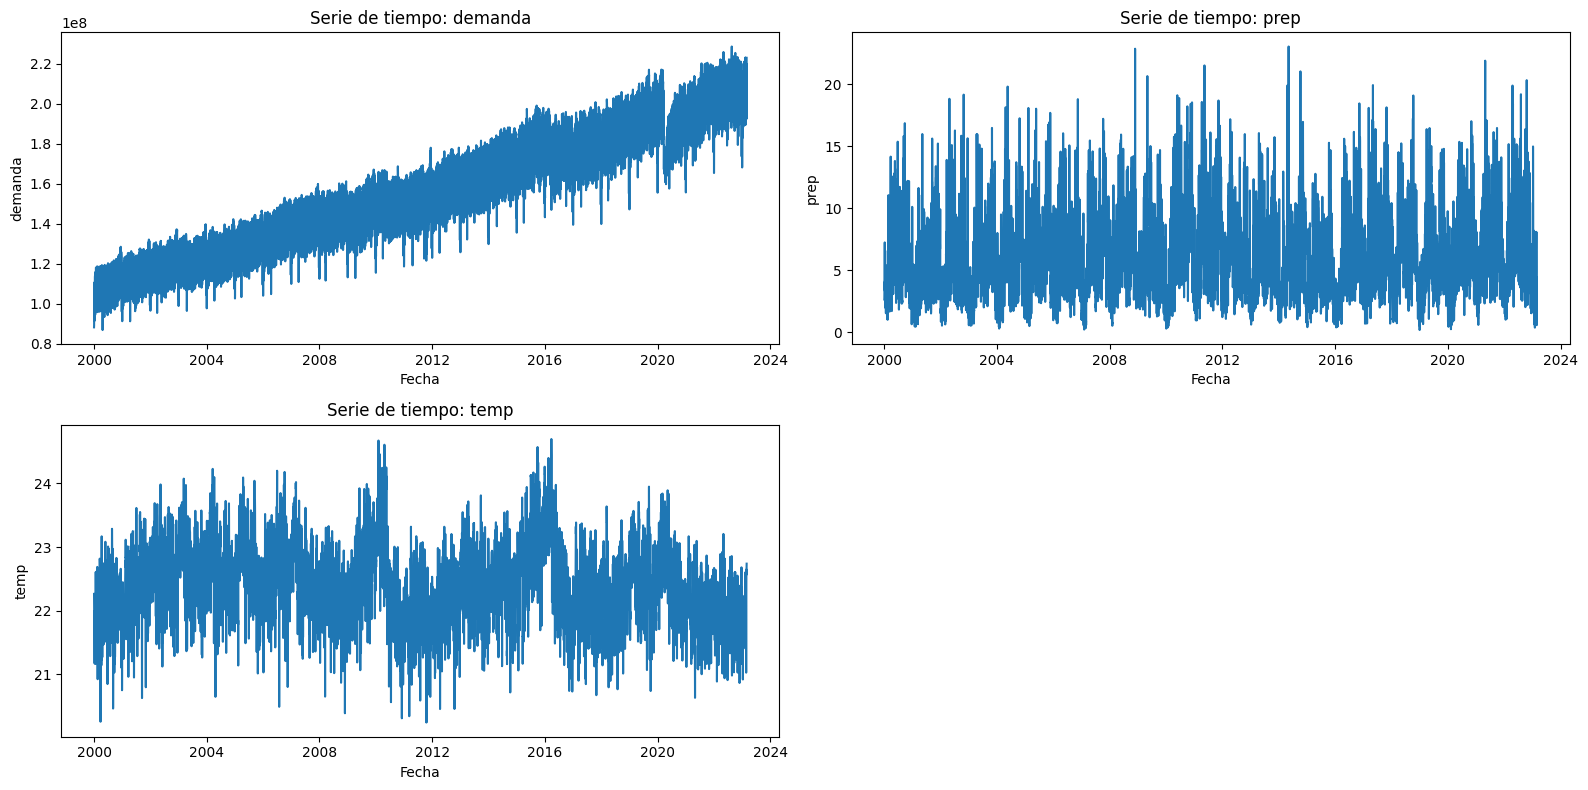

,Fecha,demanda,prep,temp
count,8460,8460.00,8460.00,8460.00
mean,2011-07-31 12:00:00,160059072.45,5.99,22.42
min,2000-01-01 00:00:00,86794068.28,0.19,20.25
25%,2005-10-15 18:00:00,133692621.41,3.48,21.99
50%,2011-07-31 12:00:00,158386417.52,5.43,22.40
75%,2017-05-15 06:00:00,185625904.64,7.99,22.83
max,2023-02-28 00:00:00,228621213.17,23.02,24.70
std,NaN,30598883.39,3.39,0.63


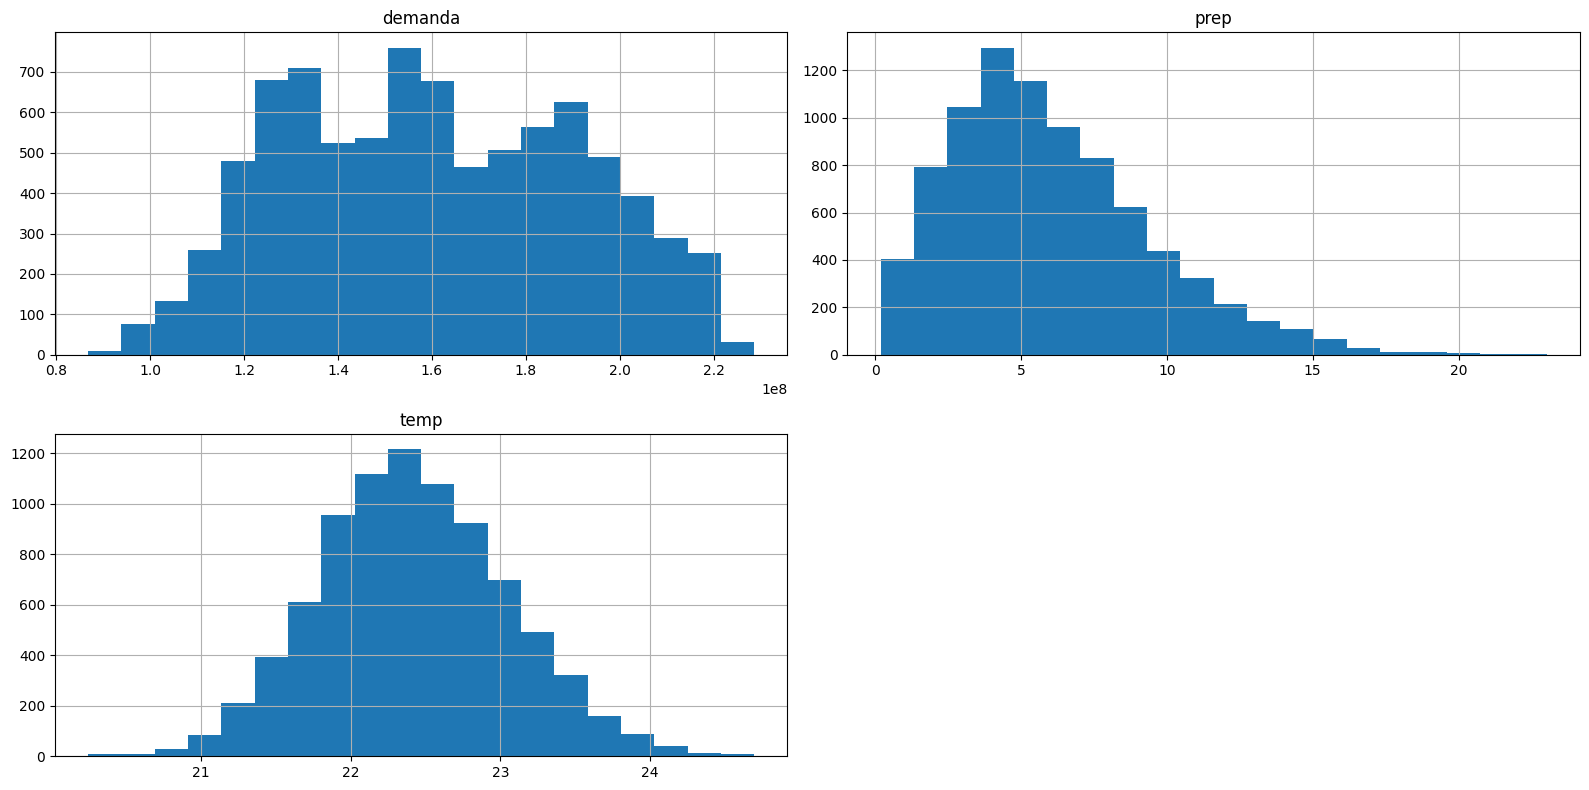

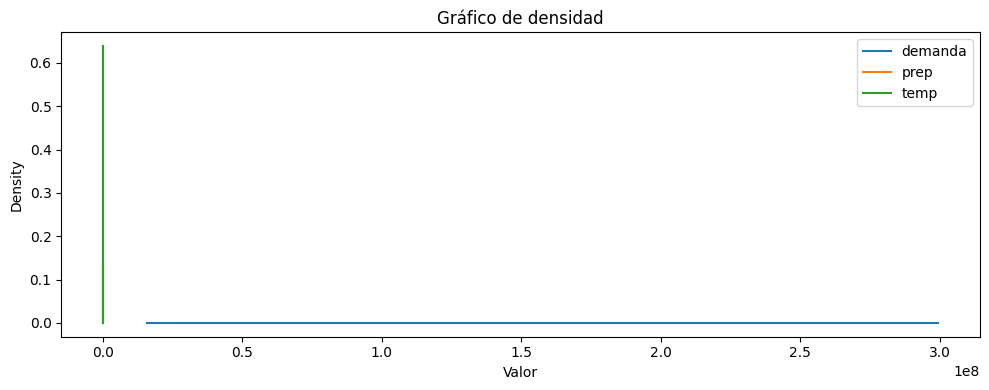

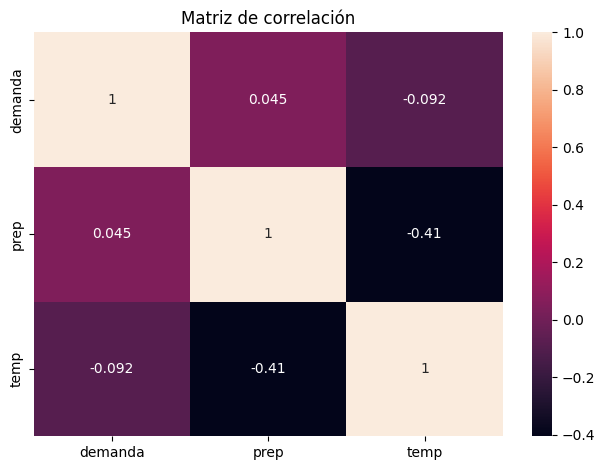

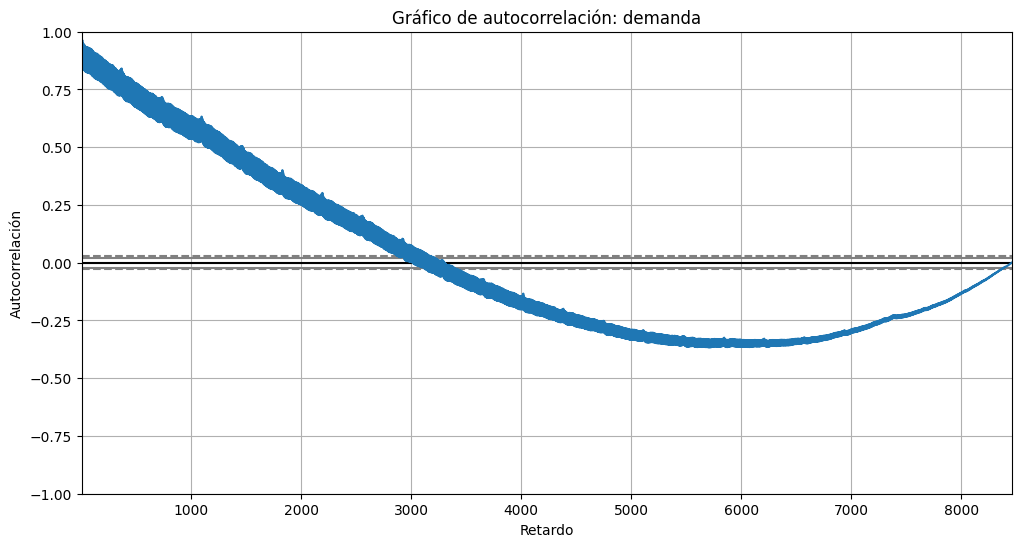

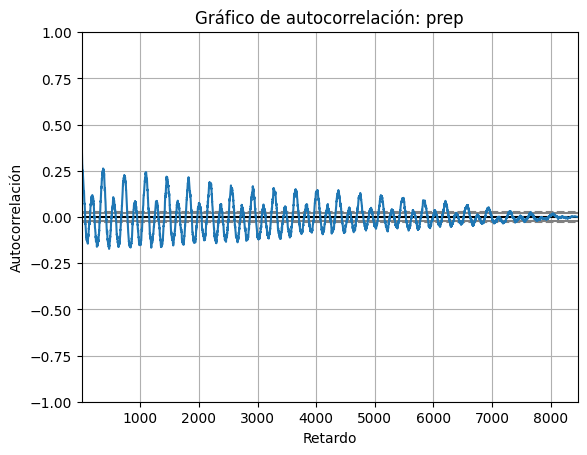

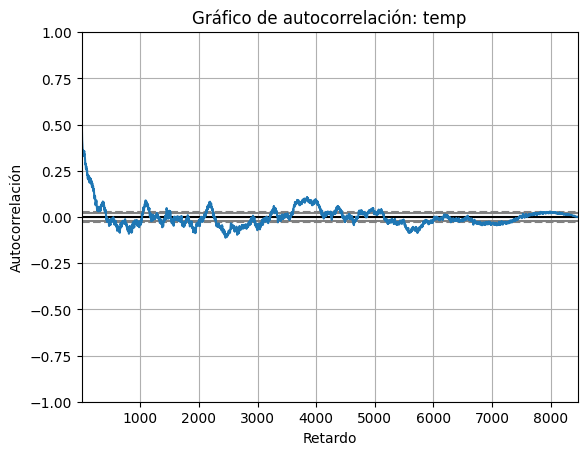

In [22]:
#merge = merge.reset_index(drop=True)
tool.demand_utilities.exploratory_time_series_analysis(df_dayli, 'D')

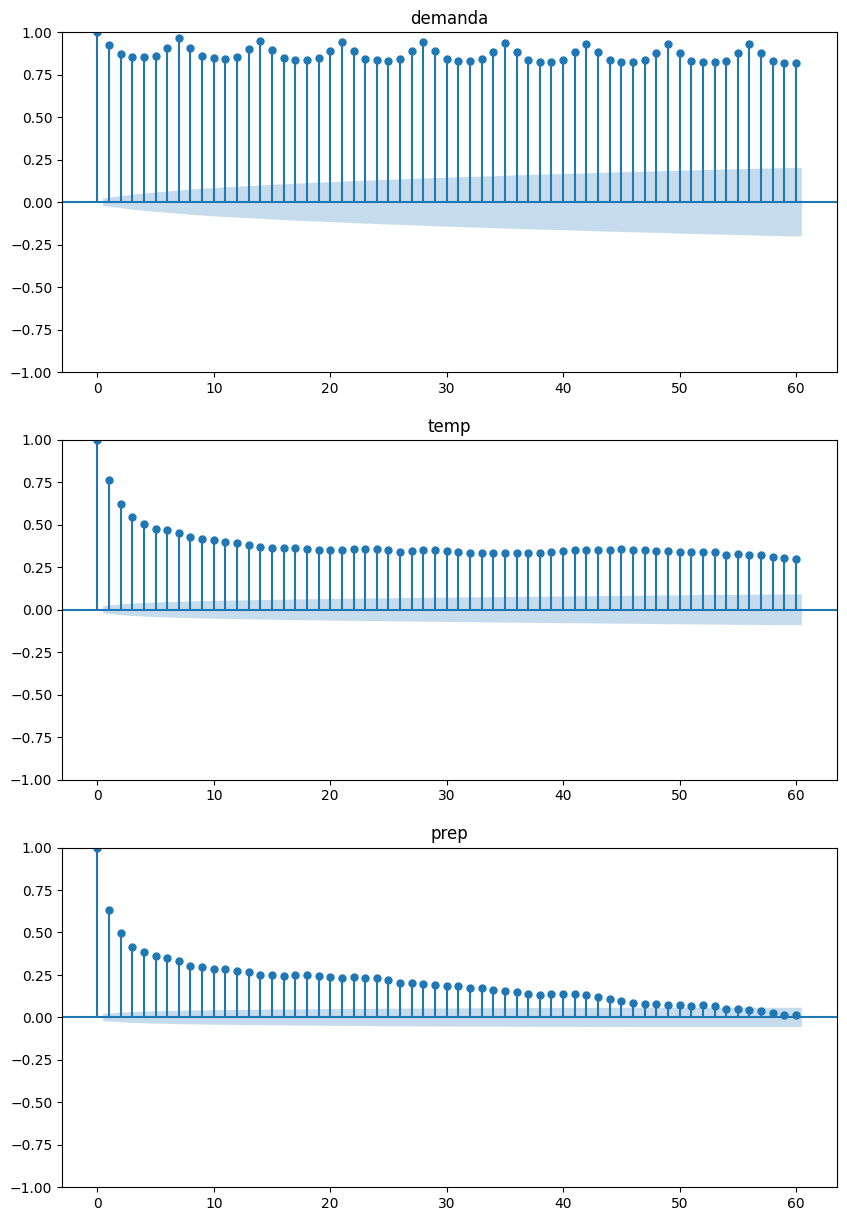

In [23]:
# asumiendo que tienes un DataFrame llamado `merge` con columnas 'demanda', 'pib' y 'pop'
tool.demand_utilities.plot_acf_subplots(df_dayli, ['demanda','temp', 'prep'])

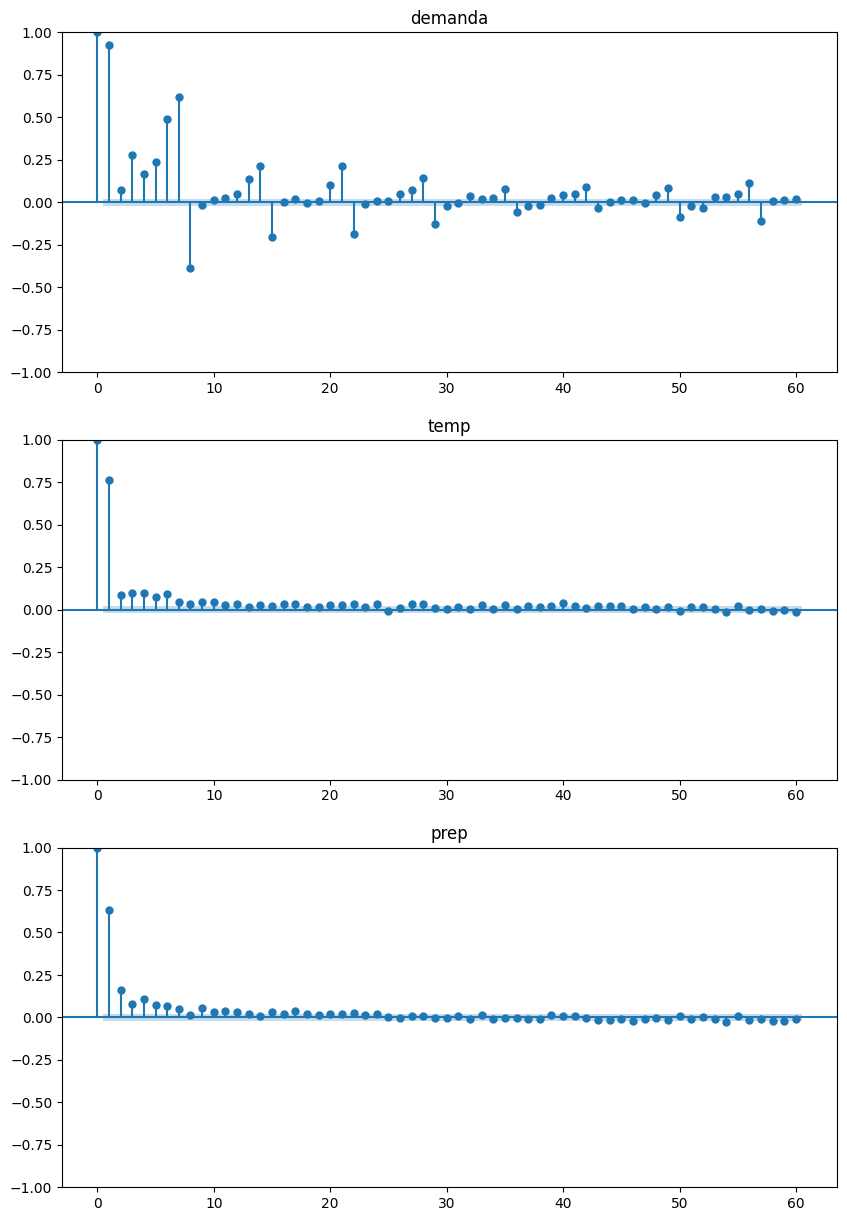

In [24]:
tool.demand_utilities.plot_pacf_subplots(df_dayli, ['demanda','temp', 'prep'])

* **adf_statistic:** El valor estadístico de la prueba ADF. Si este valor es menor que los valores críticos correspondientes, se puede rechazar la hipótesis nula de que la serie de tiempo tiene una raíz unitaria y se puede concluir que la serie de tiempo es estacionaria. Si el valor estadístico es mayor que los valores críticos, se debe aceptar la hipótesis nula y se concluye que la serie de tiempo no es estacionaria.

* **p_value:** El valor p de la prueba ADF. Si este valor es menor que el nivel de significancia elegido (por defecto 0.05), se puede rechazar la hipótesis nula y se concluye que la serie de tiempo es estacionaria. Si el valor p es mayor que el nivel de significancia, se debe aceptar la hipótesis nula y se concluye que la serie de tiempo no es estacionaria.

* **used_lags:** El número de rezagos utilizado en la prueba ADF.
* **n_observations:** El número de observaciones en la serie de tiempo.
* **critical_values:** Los valores críticos para diferentes niveles de significancia. Si el valor estadístico de la prueba ADF es menor que el valor crítico correspondiente, se puede concluir que la serie de tiempo es estacionaria.


In [37]:
# Evalúa si una serie de tiempo tiene una raíz unitaria

tool.demand_utilities.test_stationarity(df_dayli)


{'Fecha': {'adf_statistic': -30.251598470377218,
  'p_value': 0.0,
  'used_lags': 4,
  'n_observations': 8455,
  'critical_values': {'1%': -3.431123658952723,
   '5%': -2.8618819043558696,
   '10%': -2.5669519908018272}},
 'demanda': {'adf_statistic': -1.3868367625072446,
  'p_value': 0.5885702184695761,
  'used_lags': 36,
  'n_observations': 8423,
  'critical_values': {'1%': -3.4311265990735196,
   '5%': -2.861883203518417,
   '10%': -2.566952682356836}},
 'prep': {'adf_statistic': -10.192165187546221,
  'p_value': 6.280677788008149e-18,
  'used_lags': 23,
  'n_observations': 8436,
  'critical_values': {'1%': -3.4311254019584823,
   '5%': -2.8618826745447206,
   '10%': -2.5669524007797198}},
 'temp': {'adf_statistic': -6.704033154059271,
  'p_value': 3.825133828245381e-09,
  'used_lags': 36,
  'n_observations': 8423,
  'critical_values': {'1%': -3.4311265990735196,
   '5%': -2.861883203518417,
   '10%': -2.566952682356836}}}

In [38]:
tool.demand_utilities.time_series_tests(df_dayli,'demanda')

{'Prueba de la pendiente de regresión': {'nombre_prueba': 'Prueba de la pendiente de regresión',
  'resultado': None,
  'inferencia': 'No se pudieron ajustar los coeficientes de la regresión debido a la falta de variabilidad en la serie de tiempo.'},
 'Prueba de la media móvil': {'nombre_prueba': 'Prueba de la media móvil',
  'resultado': {'valor_p': 0.8185572021286187},
  'inferencia': 'Si el valor p es menor que 0.05, se puede rechazar la hipótesis nula de que la serie no tiene una tendencia significativa.'},
 'Prueba de Mann-Kendall': {'nombre_prueba': 'Prueba de Mann-Kendall',
  'resultado': {'MKScore': 0.00023642769917094224},
  'inferencia': 'Si el valor MKScore es mayor que 0 y menor que 0.25, la serie tiene una tendencia creciente con un nivel de confianza del 95%. Si el valor es menor que 0 y mayor que -0.25, la serie tiene una tendencia decreciente con un nivel de confianza del 95%.'},
 'Prueba de raíz unitaria': {'nombre_prueba': 'Prueba de la raíz unitaria',
  'resultado': 

In [39]:
tool.StationarityUtilities.kruskalWallisTest(df_dayli, 'demanda','Fecha', 0.05)

{'nombre_prueba': 'Kruskal-Wallis',
 'resultado': {'valor_p': 8459.0},
 'inferencia': 'Si el valor p es menor que 0.05, se puede rechazar la hipótesis nula de que no hay diferencias significativas entre los grupos.'}

In [40]:
df_dayli.to_parquet('df_dayli.parquet')

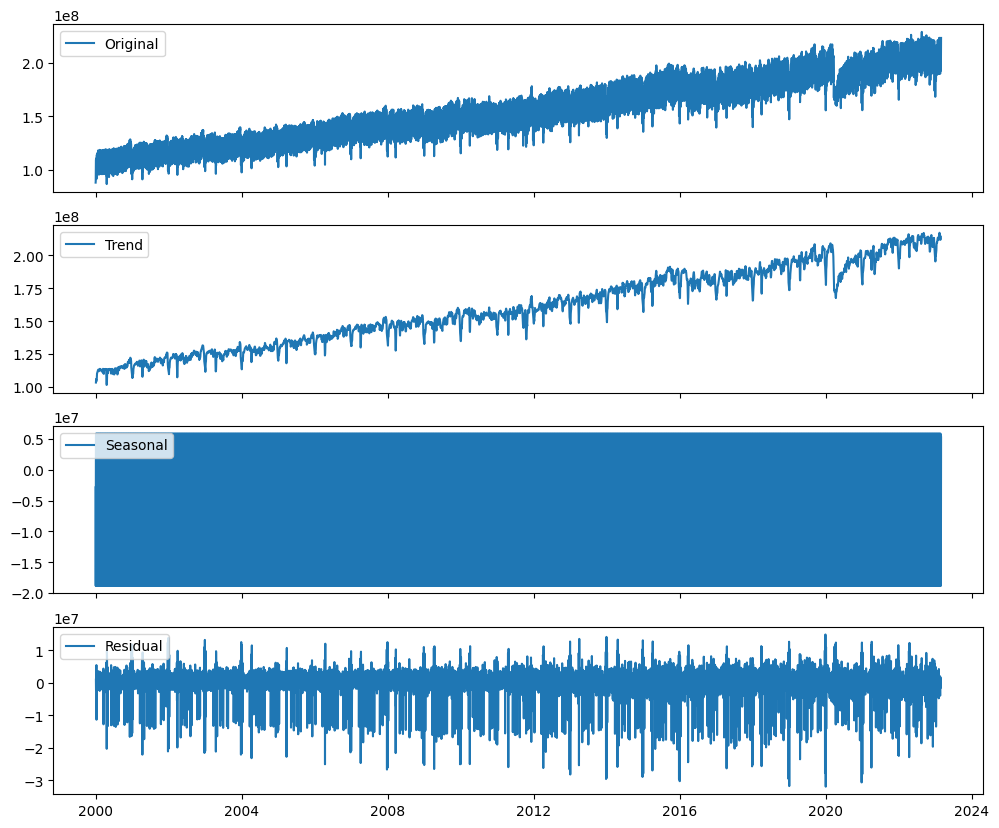

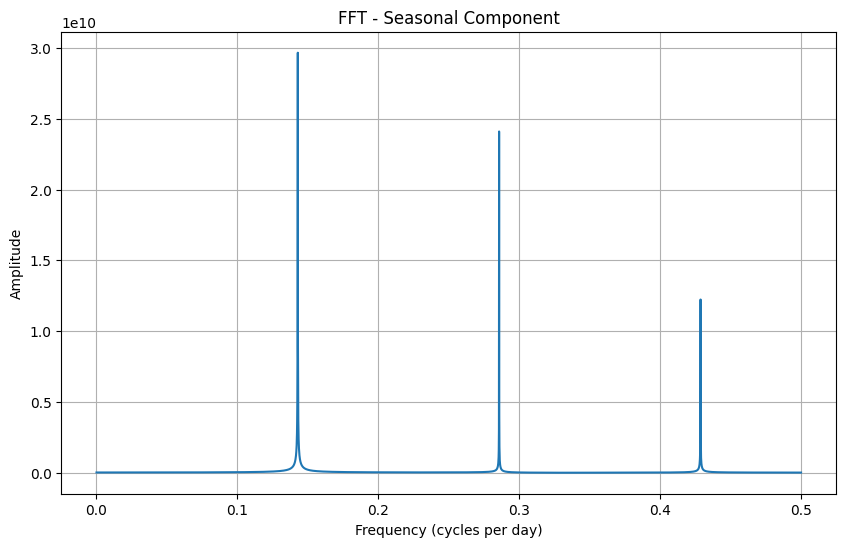

Duración del ciclo estacional: 7 días


In [41]:
df_dayli.set_index('Fecha', inplace=True)

from statsmodels.tsa.seasonal import seasonal_decompose

# Descomposición estacional
result = seasonal_decompose(df_dayli['demanda'], model='additive')  # Puedes usar 'multiplicative' si es más apropiado

# Obtener las componentes de la descomposición
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Análisis de periodicidad mediante FFT
n = len(df_dayli)
fft = np.fft.fft(seasonal)
frequencies = np.fft.fftfreq(n, 1)  # Frecuencias diarias

# Identificar la frecuencia con mayor amplitud (excepto la frecuencia cero)
amplitudes = np.abs(fft)[1:n//2]  # Ignoramos la frecuencia cero
max_amplitude_index = np.argmax(amplitudes)
dominant_frequency = frequencies[max_amplitude_index]


# Calcular la duración del ciclo estacional
if dominant_frequency > 0:
    seasonal_cycle_length = int(1 / dominant_frequency)
else:
    seasonal_cycle_length = 1



# Visualizar las componentes de la descomposición y la FFT
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

axes[0].plot(df_dayli['demanda'], label='Original')
axes[0].legend(loc='upper left')

axes[1].plot(trend, label='Trend')
axes[1].legend(loc='upper left')

axes[2].plot(seasonal, label='Seasonal')
axes[2].legend(loc='upper left')

axes[3].plot(residual, label='Residual')
axes[3].legend(loc='upper left')

# Plot FFT
plt.figure(figsize=(10, 6))
plt.plot(frequencies[1:n//2], amplitudes)
plt.xlabel('Frequency (cycles per day)')
plt.ylabel('Amplitude')
plt.title('FFT - Seasonal Component')
plt.grid(True)
plt.show()

print(f'Duración del ciclo estacional: {seasonal_cycle_length} días')

In [ ]:
#-------------------------------------------------------------------------------------------------------

## Daily to monthly

In [37]:
demand = tool.demand_utilities.datos_diarios_a_mensuales(demand,'demanda','sum') 
demand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283 entries, 0 to 282
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Año      283 non-null    int32  
 1   Mes      283 non-null    int32  
 2   demanda  283 non-null    float64
dtypes: float64(1), int32(2)
memory usage: 4.5 KB


In [39]:
year_df = demand[demand['Año'] == 2021]
pd.options.display.float_format = '{:.2f}'.format
year_df

2,Año,Mes,demanda
252,2021,1,5936883449.26
253,2021,2,5667984608.78
254,2021,3,6233302108.02
255,2021,4,6004425835.54
256,2021,5,6015209441.71
257,2021,6,6017830899.34
258,2021,7,6377147579.67
259,2021,8,6346906571.56
260,2021,9,6307744516.38
261,2021,10,6490084008.35


### Covariates

### Importar datos mensuales de clima

In [57]:
filepath_temp_mensuales = "C:/Users/JENMOSQU/Documents/PERSONAL/Datos-tesis/CLIMA/temperatura"
filepath_prep_mensuales = "C:/Users/JENMOSQU/Documents/PERSONAL/Datos-tesis/CLIMA/precipitación"

nombre_archivo_temp="datos_mensuales_temp.parquet"
nombre_archivo_prep="datos_mensuales_prep.parquet"


prep=pd.read_parquet(os.path.join(filepath_prep_mensuales, nombre_archivo_prep))
temp=pd.read_parquet(os.path.join(filepath_temp_mensuales, nombre_archivo_temp))

### Importar PIB, Población y el Ipc

In [41]:
pib = tool.demand_utilities.import_parquet_with_date("C:/Users/JENMOSQU/Documents/PERSONAL/Datos-tesis/PIB/PIB_exp.parquet", "2005-01-01", "M") #tomado de la exportación de R de la desagregación mensual
pop = tool.demand_utilities.import_parquet_with_date("C:/Users/JENMOSQU/Documents/PERSONAL/Datos-tesis/POBLACIÓN/poblacion.parquet", "2005-01-01", "M")
ipc=pd.read_excel("C:/Users/JENMOSQU/Documents/PERSONAL/Datos-tesis/IPC/ipc.xlsx")

### Formato del Ipc

In [42]:
# Convertir la columna 'mes' a formato de fecha
ipc['fecha'] = pd.to_datetime(ipc['fecha'], format='%Y%m')

# Agregar un día fijo a cada fecha para convertirla en formato "AAAA-MM-DD"
ipc['fecha'] = ipc['fecha'] + pd.offsets.Day(1)

# Convertir la columna 'mes' en un objeto de fecha mensual
ipc['fecha'] = ipc['fecha'].dt.to_period('M')
ipc.head()

,fecha,indice,inflacion,inflacion_mensual,inflacion_corr_ano
0,2000-01,40.30,8.25,1.29,1.29
1,2000-02,41.23,8.89,2.30,3.62
2,2000-03,41.93,9.73,1.71,5.39
3,2000-04,42.35,9.96,1.00,6.44
4,2000-05,42.57,10.00,0.52,7.00


In [43]:
ipc=ipc[['fecha','inflacion']]

In [44]:
print(pib.shape)
print(pop.shape)
print(ipc.shape)
print(temp.shape)
print(prep.shape)
print(demand.shape)

(217, 2)
(900, 2)
(279, 2)
(276, 3)
(276, 3)
(283, 3)


### Verificación de si un DataFrame de serie de tiempo cumple con los requisitos necesarios para su análisis

In [45]:
# Calculamos el rango de fechas manual porque con la función dice que no deja
fecha_col='fecha'
min_date = getattr(ipc, fecha_col.lower()).min()
max_date = getattr(ipc, fecha_col.lower()).max()
print('Rango de fechas:', min_date, '-', max_date)

Rango de fechas: 2000-01 - 2023-03


In [46]:
print("ipc rango",tool.demand_utilities.check_dataframe(ipc,fecha_col=ipc.columns[0],valor_col=ipc.columns[1]))

El dataframe no tiene una columna de fecha o las columnas de año, mes y inflacion
ipc rango None


In [47]:
# (MS), significa que la serie de tiempo está indexada por meses y que la frecuencia es mensual (el primer día de cada mes). La letra "M" indica que la frecuencia es mensual
print("pib rango",tool.demand_utilities.check_dataframe(pib,fecha_col='fecha',valor_col='predict.m1.'))
print("pop rango",tool.demand_utilities.check_dataframe(pop,fecha_col='fecha',valor_col='predict.m_p_7.'))
print("ipc rango",tool.demand_utilities.check_dataframe(ipc,fecha_col='fecha',valor_col='inflacion'))
print("temp rango",tool.demand_utilities.check_dataframe(temp,valor_col='Valor'))
print("prep rango",tool.demand_utilities.check_dataframe(prep,valor_col='Valor'))
print("demanda rango",tool.demand_utilities.check_dataframe(demand,valor_col='demanda'))

Frecuencia: M
Rango de fechas: 2005-01-31 00:00:00 - 2023-01-31 00:00:00
pib rango None
Frecuencia: M
Rango de fechas: 2005-01-31 00:00:00 - 2079-12-31 00:00:00
pop rango None
El dataframe no tiene una columna de fecha o las columnas de año, mes y inflacion
ipc rango None
El dataframe no tiene una columna de fecha o las columnas de año, mes y Valor
temp rango None
El dataframe no tiene una columna de fecha o las columnas de año, mes y Valor
prep rango None
El dataframe no tiene una columna de fecha o las columnas de año, mes y demanda
demanda rango None


### Formatear la columna fecha a "año-mes" de todas las variables

In [48]:
# Formatear la columna fecha a "año-mes"
pib['y-month'] = pib['fecha'].dt.strftime('%Y-%m')
pop['y-month'] = pop['fecha'].dt.strftime('%Y-%m')
ipc['y-month'] = ipc['fecha'].dt.strftime('%Y-%m')

In [49]:
temp=tool.demand_utilities.crear_columna_fecha(temp)
prep=tool.demand_utilities.crear_columna_fecha(prep)
demand=tool.demand_utilities.crear_columna_fecha(demand)

In [50]:
pib=pib[['y-month','predict.m1.']]
pop=pop[['y-month','predict.m_p_7.']]
ipc=ipc[['y-month','inflacion']]
temp=temp[['y-month','Valor']]
prep=prep[['y-month','Valor']]
demand=demand[['y-month','demanda']]

### Filtra un dataframe por un rango de fechas especificado (2005-2021)

In [51]:
pib=tool.demand_utilities.filter_dataframe_date(pib,'2005-01','2021-12')
pop=tool.demand_utilities.filter_dataframe_date(pop,'2005-01','2021-12')
ipc=tool.demand_utilities.filter_dataframe_date(ipc,'2005-01','2021-12')

temp=tool.demand_utilities.filter_dataframe_date(temp,'2005-01','2021-12')
prep=tool.demand_utilities.filter_dataframe_date(prep,'2005-01','2021-12')
demand=tool.demand_utilities.filter_dataframe_date(demand,'2005-01','2021-12')

In [52]:
print(pib.shape)
print(pop.shape)
print(ipc.shape)
print(temp.shape)
print(prep.shape)
print(demand.shape)

(204, 2)
(204, 2)
(204, 2)
(204, 2)
(204, 2)
(204, 2)


In [50]:
merge=pd.merge(demand, pib, on='y-month', how='outer')
merge=pd.merge(merge,pop, on='y-month', how='outer')
merge=pd.merge(merge,ipc, on='y-month', how='outer')
merge=pd.merge(merge, temp, on='y-month', how='outer')
merge=pd.merge(merge, prep, on='y-month', how='outer')
merge.rename(columns={'y-month':'fecha','predict.m1.':'pib','Valor_x':'temp','Valor_y':'prep','predict.m_p_7.':'pop'}, inplace=True)
merge.shape

(204, 7)

In [51]:
merge.head()

,fecha,demanda,pib,pop,inflacion,temp,prep
0,2005-01,3946789865.88,40830.58,1.11,5.43,22.61,3.64
1,2005-02,3708680497.56,42690.78,1.11,5.25,22.78,3.93
2,2005-03,4089009191.61,43081.00,1.12,5.03,23.29,4.29
3,2005-04,4056019787.78,43055.25,1.12,5.01,23.20,7.30
4,2005-05,4110809420.21,42452.48,1.13,5.04,22.90,8.44


In [52]:
merge.to_parquet('merge.parquet')

In [53]:
merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   fecha      204 non-null    object 
 1   demanda    204 non-null    float64
 2   pib        204 non-null    float64
 3   pop        204 non-null    float64
 4   inflacion  204 non-null    float64
 5   temp       204 non-null    float64
 6   prep       204 non-null    float64
dtypes: float64(6), object(1)
memory usage: 11.3+ KB


### Análisis exploratorio inicial de una serie de tiempo

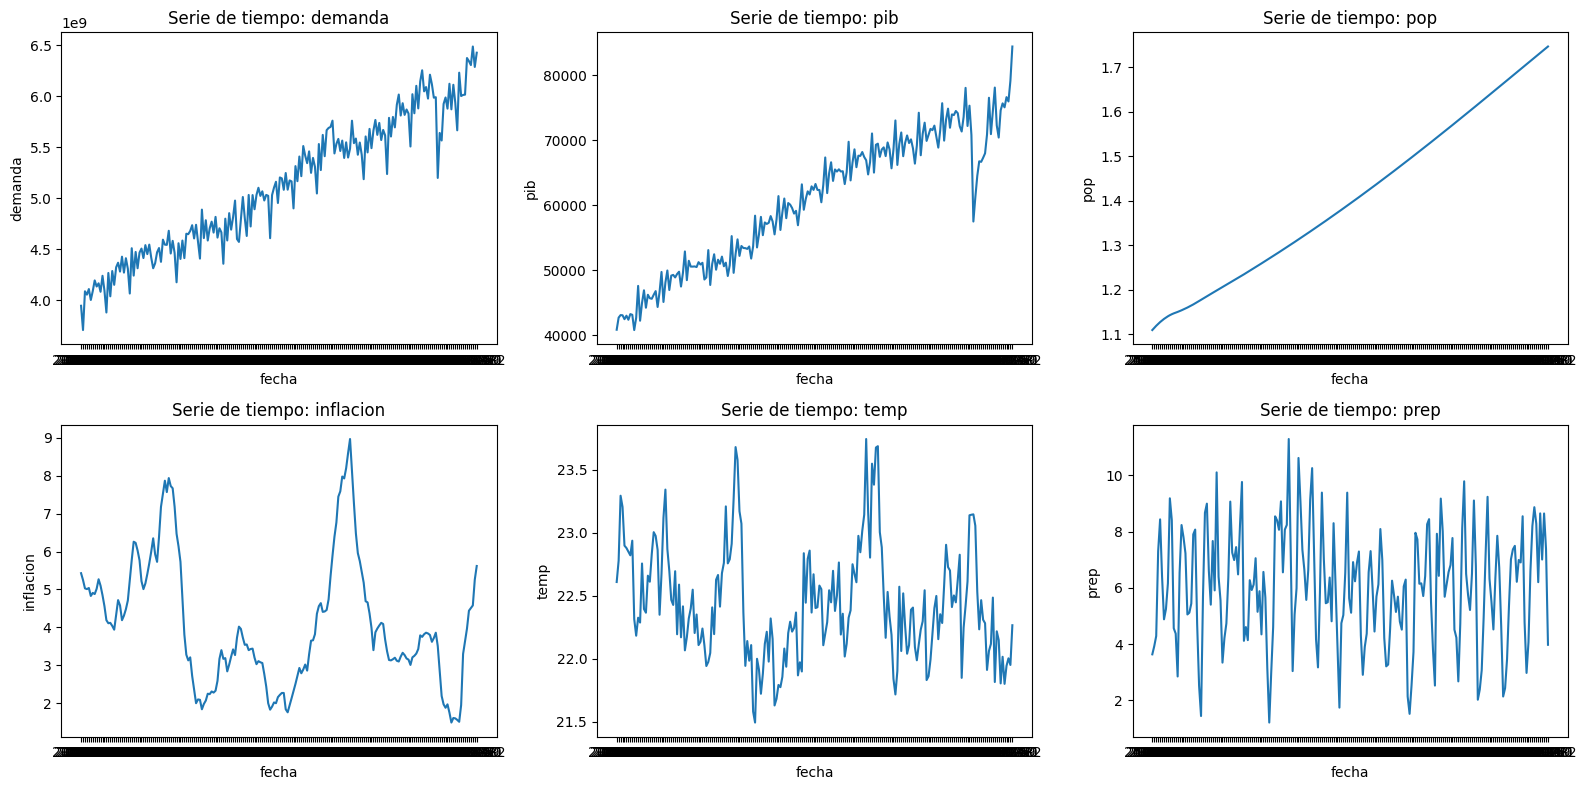

,demanda,pib,pop,inflacion,temp,prep
count,204.00,204.00,204.00,204.00,204.00,204.00
mean,5110643830.58,60556.53,1.41,4.09,22.44,6.05
std,660733003.20,10269.27,0.18,1.68,0.45,2.02
min,3708680497.56,40782.29,1.11,1.49,21.50,1.22
25%,4556807354.23,51086.21,1.24,3.02,22.12,4.61
50%,5085152022.65,61976.59,1.39,3.79,22.38,6.16
75%,5647889563.40,69306.49,1.56,5.03,22.71,7.37
max,6490084008.35,84385.18,1.75,8.97,23.74,11.29


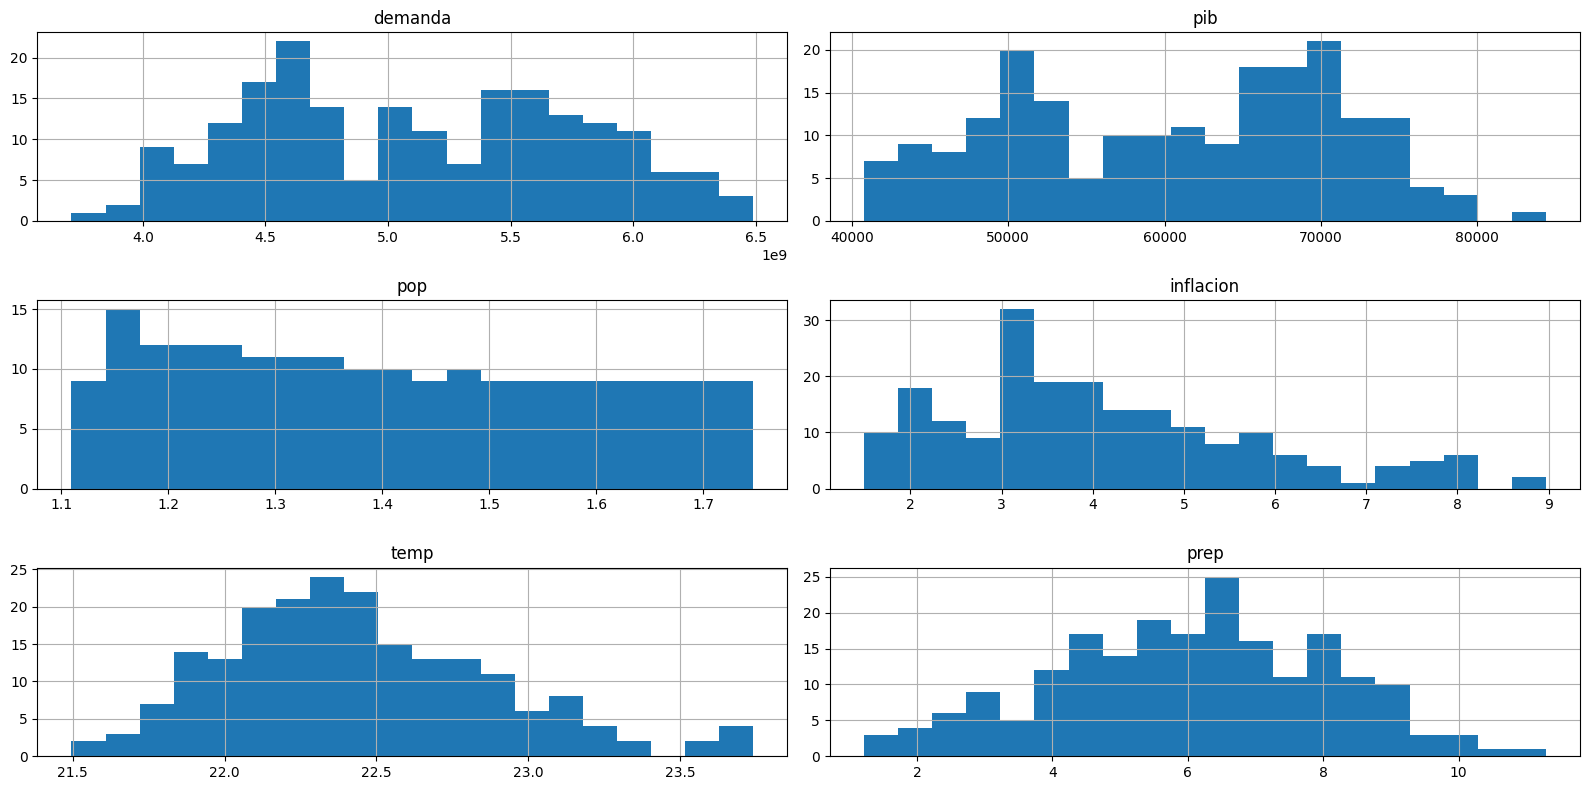

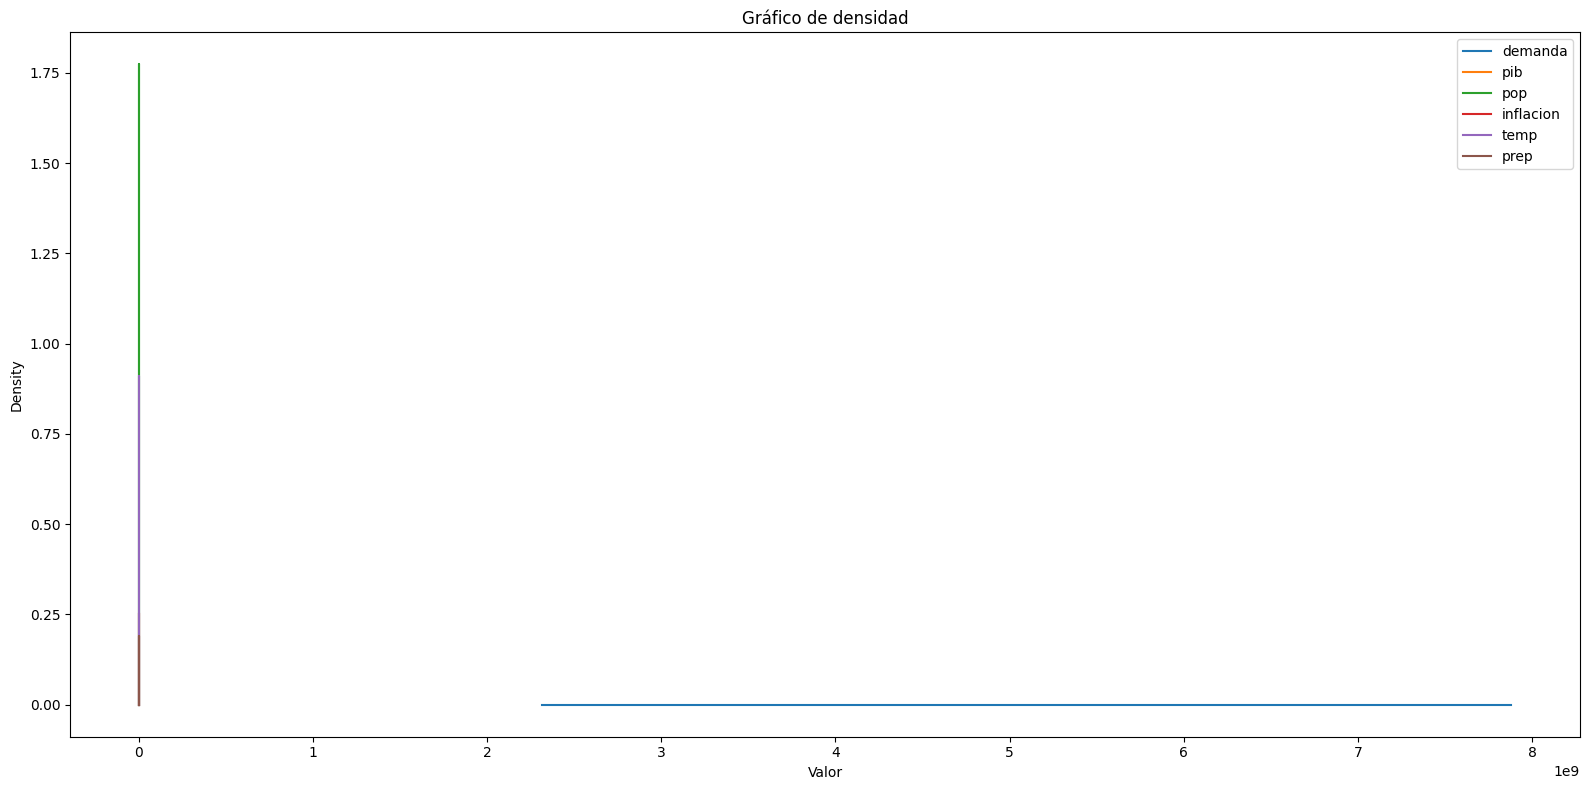

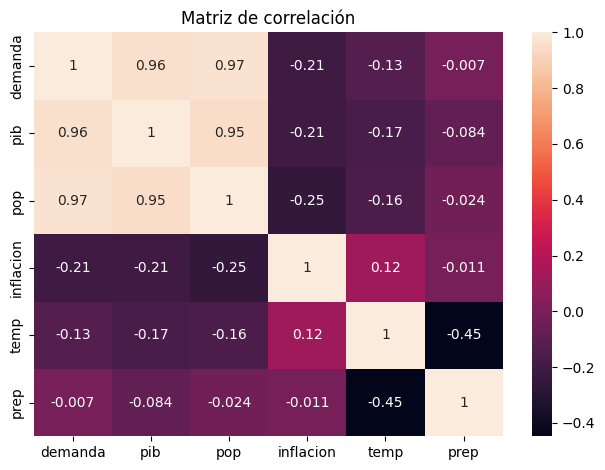

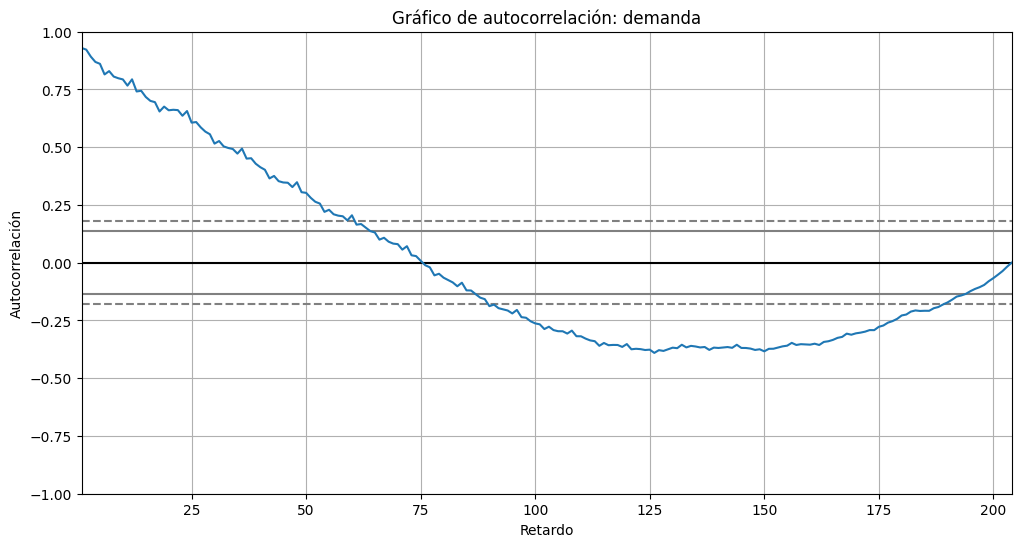

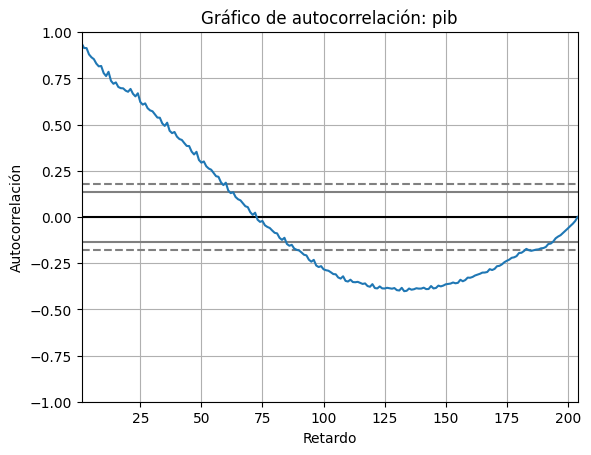

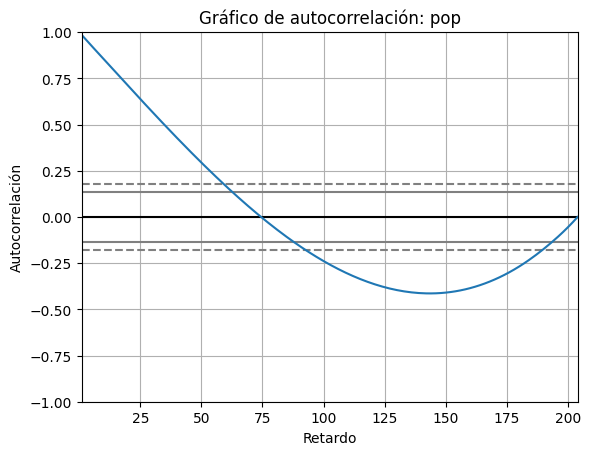

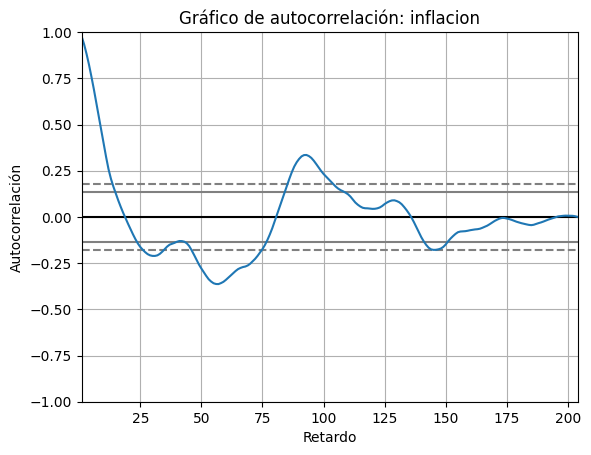

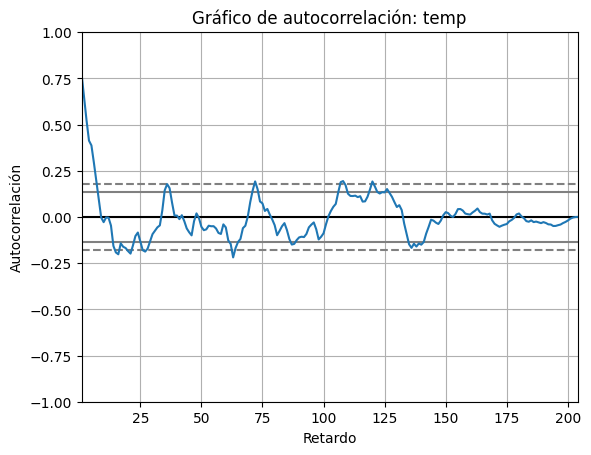

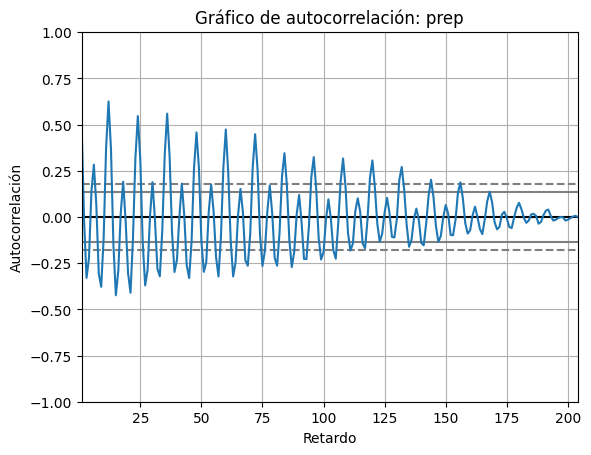

In [54]:
merge = merge.reset_index(drop=True)
tool.demand_utilities.exploratory_time_series_analysis(merge, 'M')


### ACF

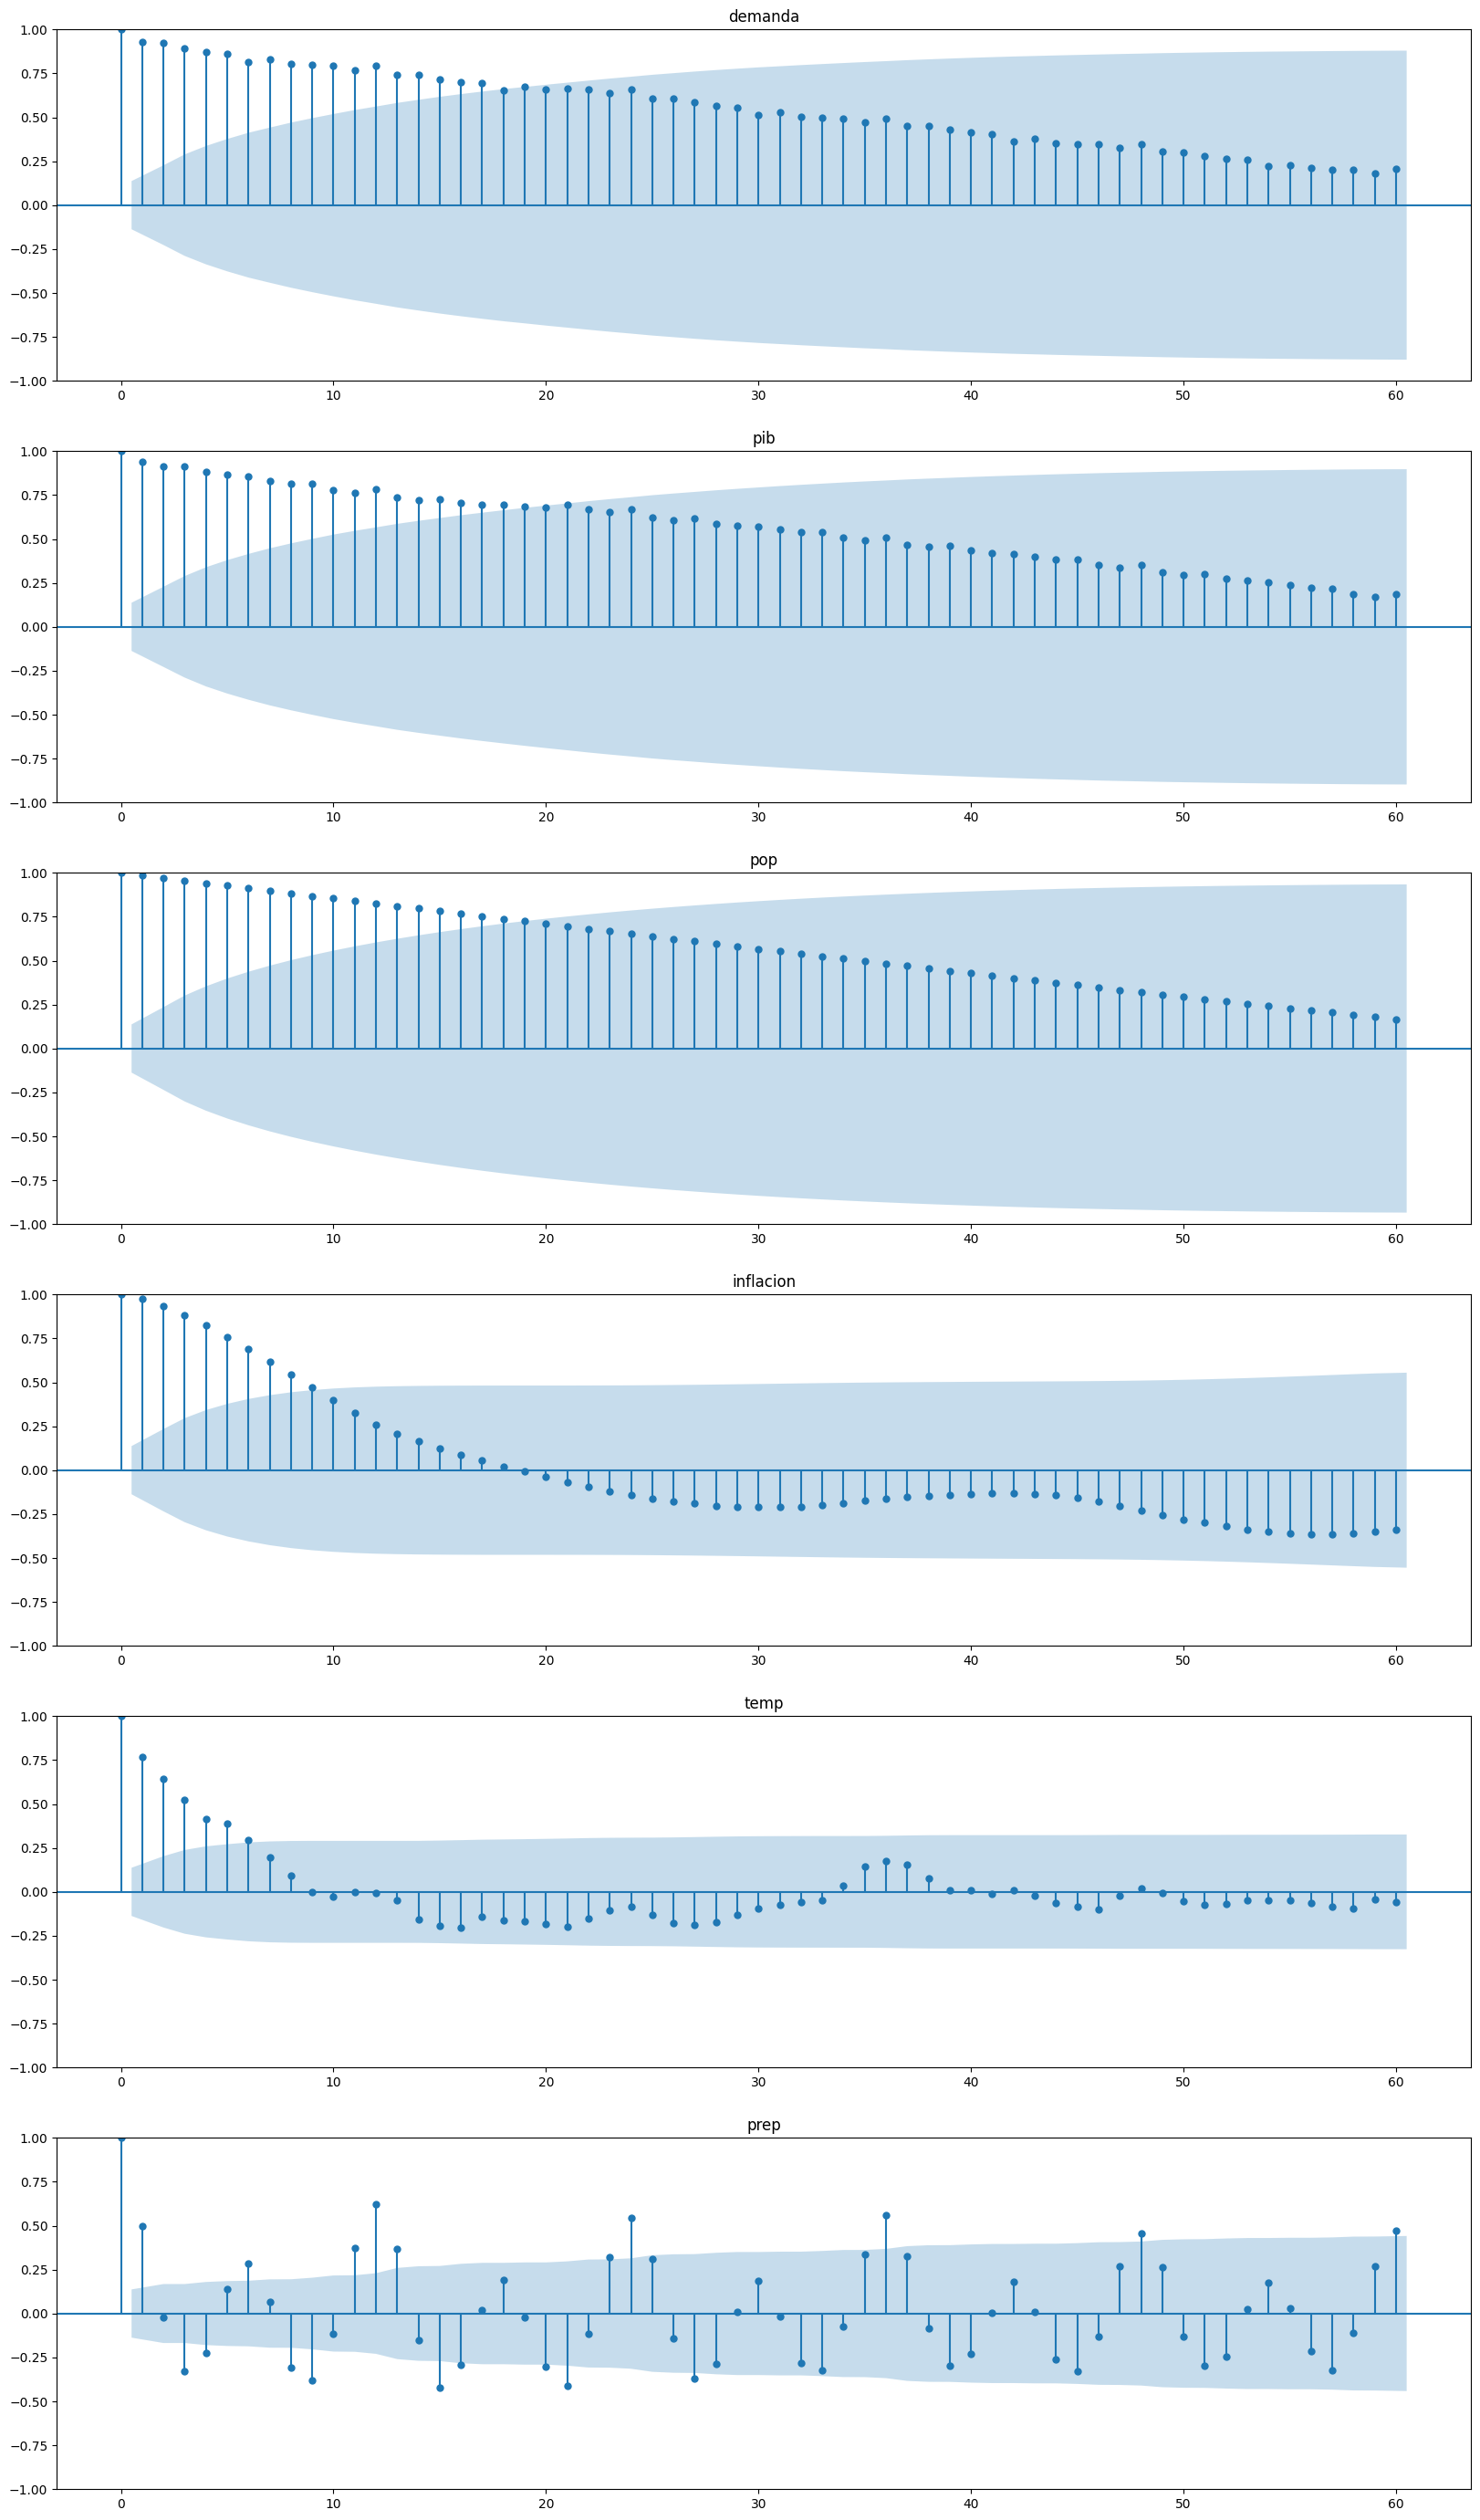

In [55]:
# asumiendo que tienes un DataFrame llamado `merge` con columnas 'demanda', 'pib' y 'pop'
tool.demand_utilities.plot_acf_subplots(merge, ['demanda', 'pib', 'pop', 'inflacion', 'temp', 'prep'])

### PACF

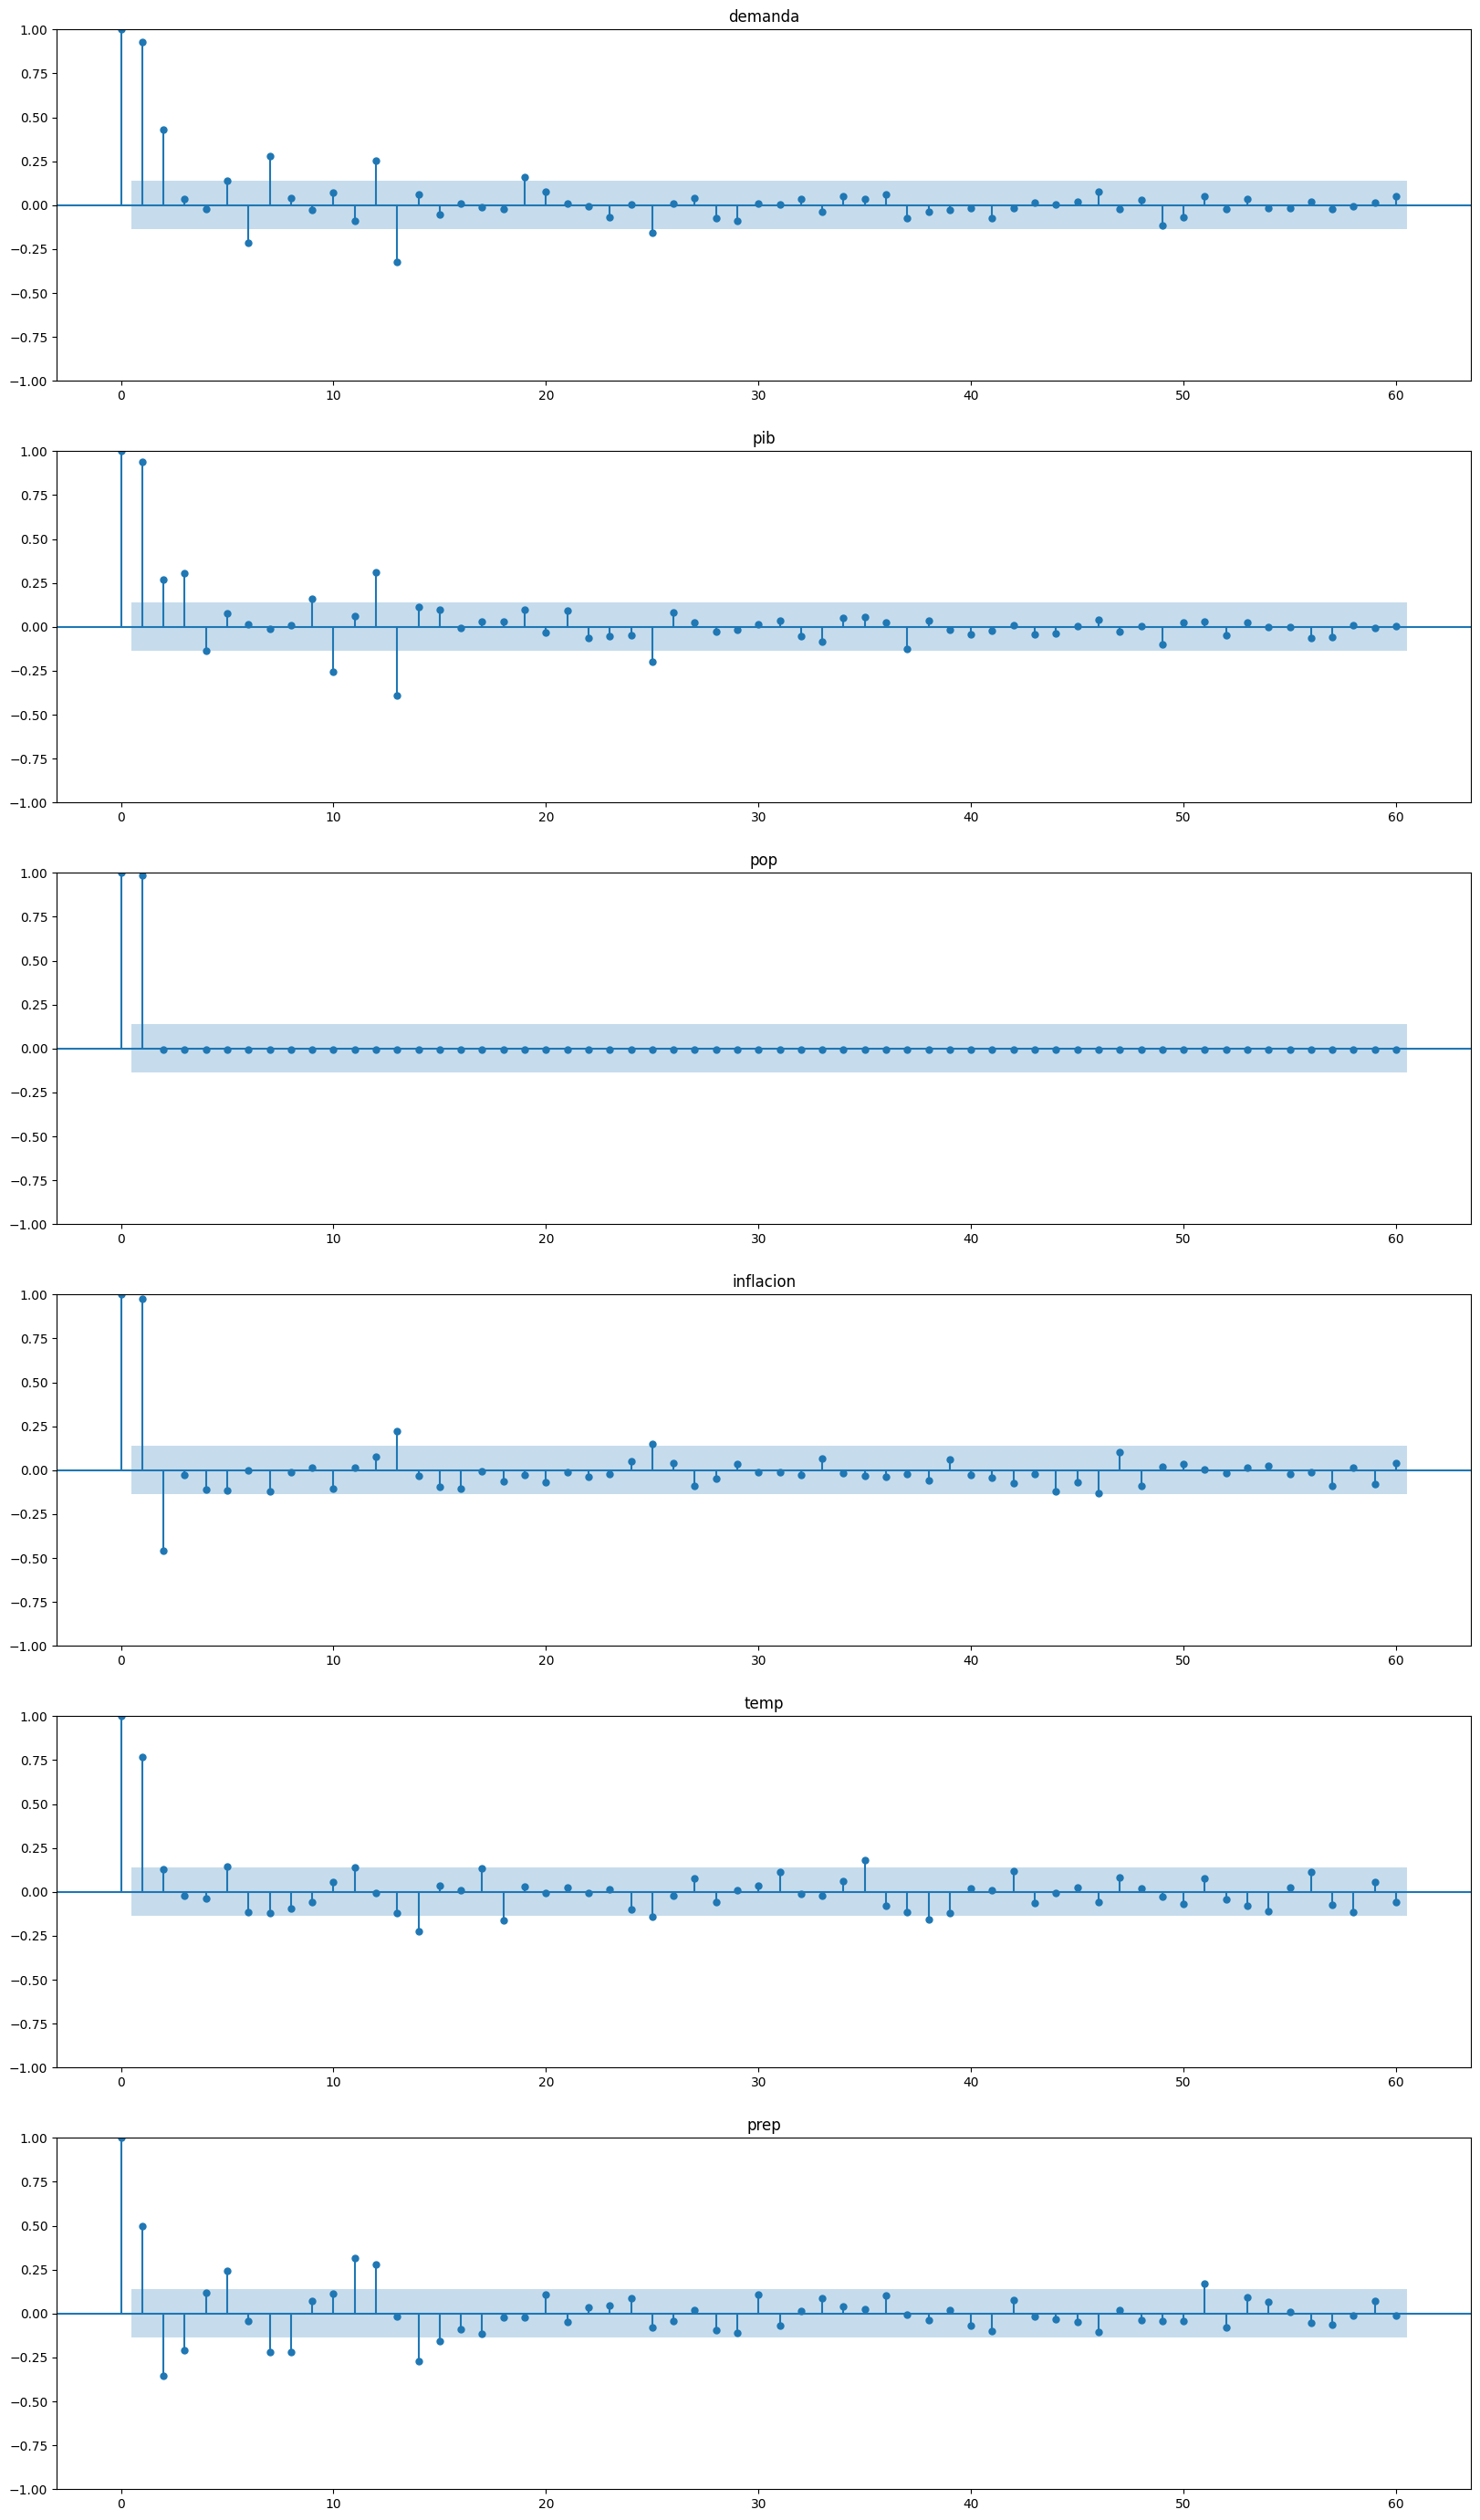

In [56]:
tool.demand_utilities.plot_pacf_subplots(merge, ['demanda', 'pib', 'pop', 'inflacion', 'temp', 'prep'])

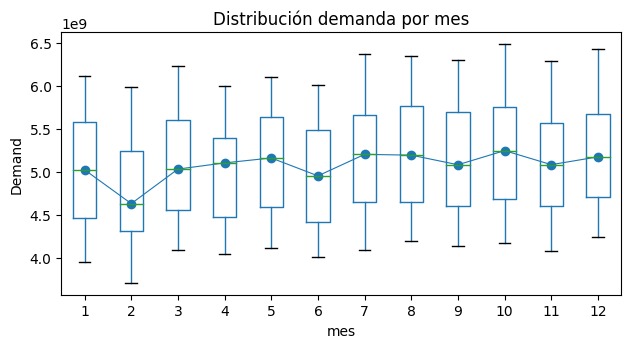

In [58]:
#FORMATO
merge['fecha'] = pd.to_datetime(merge['fecha'])
merge['mes'] = merge['fecha'].dt.month


# Gráfico boxplot para estacionalidad anual
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))
merge.boxplot(column='demanda', by='mes', ax=ax,)
merge.groupby('mes')['demanda'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por mes')
fig.suptitle('');

### Evaluación de estacionariedad

In [59]:
# Evalúa si una serie de tiempo tiene una raíz unitaria: serie de tiempo no es estacionaria
results = tool.demand_utilities.test_stationarity(merge)


* **adf_statistic:** El valor estadístico de la prueba ADF. Si este valor es menor que los valores críticos correspondientes, se puede rechazar la hipótesis nula de que la serie de tiempo tiene una raíz unitaria y se puede concluir que la serie de tiempo es estacionaria. Si el valor estadístico es mayor que los valores críticos, se debe aceptar la hipótesis nula y se concluye que la serie de tiempo no es estacionaria.

* **p_value:** El valor p de la prueba ADF. Si este valor es menor que el nivel de significancia elegido (por defecto 0.05), se puede rechazar la hipótesis nula y se concluye que la serie de tiempo es estacionaria. Si el valor p es mayor que el nivel de significancia, se debe aceptar la hipótesis nula y se concluye que la serie de tiempo no es estacionaria.

* **used_lags:** El número de rezagos utilizado en la prueba ADF.
* **n_observations:** El número de observaciones en la serie de tiempo.
* **critical_values:** Los valores críticos para diferentes niveles de significancia. Si el valor estadístico de la prueba ADF es menor que el valor crítico correspondiente, se puede concluir que la serie de tiempo es estacionaria.


In [60]:
results

{'fecha': {'adf_statistic': -0.20364465393179879,
  'p_value': 0.9380857877179625,
  'used_lags': 12,
  'n_observations': 191,
  'critical_values': {'1%': -3.465058702600837,
   '5%': -2.8767942675230356,
   '10%': -2.5749014492475535}},
 'demanda': {'adf_statistic': -0.0364632415983303,
  'p_value': 0.9554106980740473,
  'used_lags': 12,
  'n_observations': 191,
  'critical_values': {'1%': -3.465058702600837,
   '5%': -2.8767942675230356,
   '10%': -2.5749014492475535}},
 'pib': {'adf_statistic': -0.5834631316800543,
  'p_value': 0.8746750705375593,
  'used_lags': 12,
  'n_observations': 191,
  'critical_values': {'1%': -3.465058702600837,
   '5%': -2.8767942675230356,
   '10%': -2.5749014492475535}},
 'pop': {'adf_statistic': -3.6904883450340815,
  'p_value': 0.004248950785459667,
  'used_lags': 14,
  'n_observations': 189,
  'critical_values': {'1%': -3.4654311561944873,
   '5%': -2.8769570530458792,
   '10%': -2.574988319755886}},
 'inflacion': {'adf_statistic': -2.3752825389758576

### Análisis de tendencia

In [61]:
tool.demand_utilities.time_series_tests(merge,'demanda')

{'Prueba de la pendiente de regresión': {'nombre_prueba': 'Prueba de la pendiente de regresión',
  'resultado': None,
  'inferencia': 'No se pudieron ajustar los coeficientes de la regresión debido a la falta de variabilidad en la serie de tiempo.'},
 'Prueba de la media móvil': {'nombre_prueba': 'Prueba de la media móvil',
  'resultado': {'valor_p': 0.9377392046687422},
  'inferencia': 'Si el valor p es menor que 0.05, se puede rechazar la hipótesis nula de que la serie no tiene una tendencia significativa.'},
 'Prueba de Mann-Kendall': {'nombre_prueba': 'Prueba de Mann-Kendall',
  'resultado': {'MKScore': 0.009842627776974647},
  'inferencia': 'Si el valor MKScore es mayor que 0 y menor que 0.25, la serie tiene una tendencia creciente con un nivel de confianza del 95%. Si el valor es menor que 0 y mayor que -0.25, la serie tiene una tendencia decreciente con un nivel de confianza del 95%.'},
 'Prueba de raíz unitaria': {'nombre_prueba': 'Prueba de la raíz unitaria',
  'resultado': {'

In [62]:
tool.demand_utilities.time_series_tests(merge,'pib')

{'Prueba de la pendiente de regresión': {'nombre_prueba': 'Prueba de la pendiente de regresión',
  'resultado': None,
  'inferencia': 'No se pudieron ajustar los coeficientes de la regresión debido a la falta de variabilidad en la serie de tiempo.'},
 'Prueba de la media móvil': {'nombre_prueba': 'Prueba de la media móvil',
  'resultado': {'valor_p': 0.5040399260223964},
  'inferencia': 'Si el valor p es menor que 0.05, se puede rechazar la hipótesis nula de que la serie no tiene una tendencia significativa.'},
 'Prueba de Mann-Kendall': {'nombre_prueba': 'Prueba de Mann-Kendall',
  'resultado': {'MKScore': 0.009828152939423657},
  'inferencia': 'Si el valor MKScore es mayor que 0 y menor que 0.25, la serie tiene una tendencia creciente con un nivel de confianza del 95%. Si el valor es menor que 0 y mayor que -0.25, la serie tiene una tendencia decreciente con un nivel de confianza del 95%.'},
 'Prueba de raíz unitaria': {'nombre_prueba': 'Prueba de la raíz unitaria',
  'resultado': {'

In [63]:
tool.demand_utilities.time_series_tests(merge,'pop')

{'Prueba de la pendiente de regresión': {'nombre_prueba': 'Prueba de la pendiente de regresión',
  'resultado': None,
  'inferencia': 'No se pudieron ajustar los coeficientes de la regresión debido a la falta de variabilidad en la serie de tiempo.'},
 'Prueba de la media móvil': {'nombre_prueba': 'Prueba de la media móvil',
  'resultado': {'valor_p': 0.8203449120211633},
  'inferencia': 'Si el valor p es menor que 0.05, se puede rechazar la hipótesis nula de que la serie no tiene una tendencia significativa.'},
 'Prueba de Mann-Kendall': {'nombre_prueba': 'Prueba de Mann-Kendall',
  'resultado': {'MKScore': 0.009852199501789909},
  'inferencia': 'Si el valor MKScore es mayor que 0 y menor que 0.25, la serie tiene una tendencia creciente con un nivel de confianza del 95%. Si el valor es menor que 0 y mayor que -0.25, la serie tiene una tendencia decreciente con un nivel de confianza del 95%.'},
 'Prueba de raíz unitaria': {'nombre_prueba': 'Prueba de la raíz unitaria',
  'resultado': {'

In [64]:
tool.demand_utilities.time_series_tests(merge,'inflacion')

{'Prueba de la pendiente de regresión': {'nombre_prueba': 'Prueba de la pendiente de regresión',
  'resultado': None,
  'inferencia': 'No se pudieron ajustar los coeficientes de la regresión debido a la falta de variabilidad en la serie de tiempo.'},
 'Prueba de la media móvil': {'nombre_prueba': 'Prueba de la media móvil',
  'resultado': {'valor_p': 0.050472179477855435},
  'inferencia': 'Si el valor p es menor que 0.05, se puede rechazar la hipótesis nula de que la serie no tiene una tendencia significativa.'},
 'Prueba de Mann-Kendall': {'nombre_prueba': 'Prueba de Mann-Kendall',
  'resultado': {'MKScore': 0.009825098703463025},
  'inferencia': 'Si el valor MKScore es mayor que 0 y menor que 0.25, la serie tiene una tendencia creciente con un nivel de confianza del 95%. Si el valor es menor que 0 y mayor que -0.25, la serie tiene una tendencia decreciente con un nivel de confianza del 95%.'},
 'Prueba de raíz unitaria': {'nombre_prueba': 'Prueba de la raíz unitaria',
  'resultado': 

In [65]:
tool.demand_utilities.time_series_tests(merge,'temp')

{'Prueba de la pendiente de regresión': {'nombre_prueba': 'Prueba de la pendiente de regresión',
  'resultado': None,
  'inferencia': 'No se pudieron ajustar los coeficientes de la regresión debido a la falta de variabilidad en la serie de tiempo.'},
 'Prueba de la media móvil': {'nombre_prueba': 'Prueba de la media móvil',
  'resultado': {'valor_p': 0.0013663053199456897},
  'inferencia': 'Si el valor p es menor que 0.05, se puede rechazar la hipótesis nula de que la serie no tiene una tendencia significativa.'},
 'Prueba de Mann-Kendall': {'nombre_prueba': 'Prueba de Mann-Kendall',
  'resultado': {'MKScore': 0.009608920865522924},
  'inferencia': 'Si el valor MKScore es mayor que 0 y menor que 0.25, la serie tiene una tendencia creciente con un nivel de confianza del 95%. Si el valor es menor que 0 y mayor que -0.25, la serie tiene una tendencia decreciente con un nivel de confianza del 95%.'},
 'Prueba de raíz unitaria': {'nombre_prueba': 'Prueba de la raíz unitaria',
  'resultado':

In [66]:
tool.demand_utilities.time_series_tests(merge,'prep')

{'Prueba de la pendiente de regresión': {'nombre_prueba': 'Prueba de la pendiente de regresión',
  'resultado': None,
  'inferencia': 'No se pudieron ajustar los coeficientes de la regresión debido a la falta de variabilidad en la serie de tiempo.'},
 'Prueba de la media móvil': {'nombre_prueba': 'Prueba de la media móvil',
  'resultado': {'valor_p': 0.10438782240122157},
  'inferencia': 'Si el valor p es menor que 0.05, se puede rechazar la hipótesis nula de que la serie no tiene una tendencia significativa.'},
 'Prueba de Mann-Kendall': {'nombre_prueba': 'Prueba de Mann-Kendall',
  'resultado': {'MKScore': 0.009648327692058423},
  'inferencia': 'Si el valor MKScore es mayor que 0 y menor que 0.25, la serie tiene una tendencia creciente con un nivel de confianza del 95%. Si el valor es menor que 0 y mayor que -0.25, la serie tiene una tendencia decreciente con un nivel de confianza del 95%.'},
 'Prueba de raíz unitaria': {'nombre_prueba': 'Prueba de la raíz unitaria',
  'resultado': {

### Análisis de estacionalidad

In [67]:
tool.StationarityUtilities.kruskalWallisTest(merge, 'demanda','mes', 0.05)

{'nombre_prueba': 'Kruskal-Wallis',
 'resultado': {'valor_p': 8.80747742425524},
 'inferencia': 'Si el valor p es menor que 0.05, se puede rechazar la hipótesis nula de que no hay diferencias significativas entre los grupos.'}

In [68]:
tool.StationarityUtilities.kruskalWallisTest(merge, 'pib','mes', 0.05)

{'nombre_prueba': 'Kruskal-Wallis',
 'resultado': {'valor_p': 6.471145244324362},
 'inferencia': 'Si el valor p es menor que 0.05, se puede rechazar la hipótesis nula de que no hay diferencias significativas entre los grupos.'}

In [69]:
tool.StationarityUtilities.kruskalWallisTest(merge, 'pop','mes', 0.05)

{'nombre_prueba': 'Kruskal-Wallis',
 'resultado': {'valor_p': 0.6975609756096901},
 'inferencia': 'Si el valor p es menor que 0.05, se puede rechazar la hipótesis nula de que no hay diferencias significativas entre los grupos.'}

In [70]:
tool.StationarityUtilities.kruskalWallisTest(merge, 'inflacion','mes', 0.05)

{'nombre_prueba': 'Kruskal-Wallis',
 'resultado': {'valor_p': 0.3105060182118334},
 'inferencia': 'Si el valor p es menor que 0.05, se puede rechazar la hipótesis nula de que no hay diferencias significativas entre los grupos.'}

In [71]:
tool.StationarityUtilities.kruskalWallisTest(merge, 'temp','mes', 0.05)

{'nombre_prueba': 'Kruskal-Wallis',
 'resultado': {'valor_p': 28.185146425858647},
 'inferencia': 'Si el valor p es menor que 0.05, se puede rechazar la hipótesis nula de que no hay diferencias significativas entre los grupos.'}

In [72]:
tool.StationarityUtilities.kruskalWallisTest(merge, 'prep','mes', 0.05)

{'nombre_prueba': 'Kruskal-Wallis',
 'resultado': {'valor_p': 139.69359439615152},
 'inferencia': 'Si el valor p es menor que 0.05, se puede rechazar la hipótesis nula de que no hay diferencias significativas entre los grupos.'}

In [73]:
tool.StationarityUtilities.kruskalWallisTest(merge, 'prep','mes', 0.05)

{'nombre_prueba': 'Kruskal-Wallis',
 'resultado': {'valor_p': 139.69359439615152},
 'inferencia': 'Si el valor p es menor que 0.05, se puede rechazar la hipótesis nula de que no hay diferencias significativas entre los grupos.'}

#### Friedman seasonality test

In [74]:
tool.StationarityUtilities.FriedmanSeasonality_test(merge, 'demanda')

El p-valor es 2.0601967546481065e-23, por lo tanto, se puede inferir que hay patrones estacionales significativos.


(134.5746606334842, 2.0601967546481065e-23)

In [75]:
tool.StationarityUtilities.FriedmanSeasonality_test(merge, 'pib')

El p-valor es 6.208241445590497e-21, por lo tanto, se puede inferir que hay patrones estacionales significativos.


(122.31221719457017, 6.208241445590497e-21)

In [76]:
tool.StationarityUtilities.FriedmanSeasonality_test(merge, 'pop')

El p-valor es 3.668106954474034e-34, por lo tanto, se puede inferir que hay patrones estacionales significativos.


(187.0000000000001, 3.668106954474034e-34)

In [77]:
tool.StationarityUtilities.FriedmanSeasonality_test(merge, 'inflacion')

El p-valor es 0.937747248919929, por lo tanto, no se puede inferir que hay patrones estacionales significativos.


(4.860201770640428, 0.937747248919929)

In [78]:
tool.StationarityUtilities.FriedmanSeasonality_test(merge, 'temp')

El p-valor es 6.321662603927836e-05, por lo tanto, se puede inferir que hay patrones estacionales significativos.


(38.54751131221724, 6.321662603927836e-05)

In [79]:
tool.StationarityUtilities.FriedmanSeasonality_test(merge, 'prep')

El p-valor es 1.9013651174278907e-24, por lo tanto, se puede inferir que hay patrones estacionales significativos.


(139.66968325791868, 1.9013651174278907e-24)

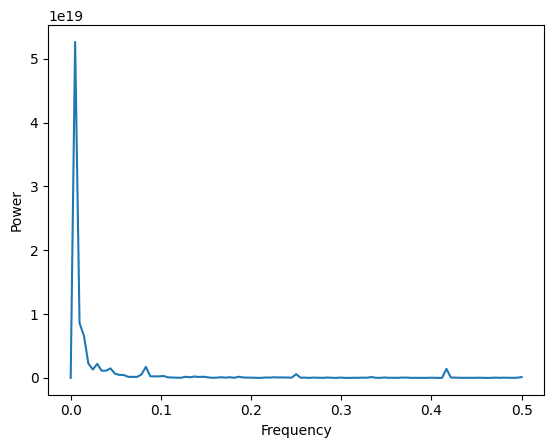

(0.004901960784313725, 'No hay evidencia de periodicidad en los datos')

In [80]:
tool.StationarityUtilities.PeriodogramTest(merge['demanda'])

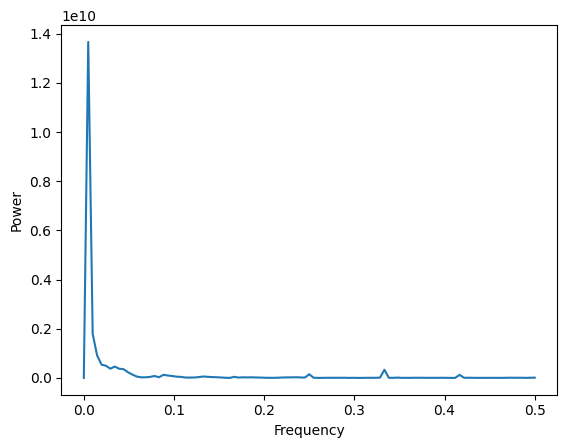

(0.004901960784313725, 'No hay evidencia de periodicidad en los datos')

In [81]:
tool.StationarityUtilities.PeriodogramTest(merge['pib'])

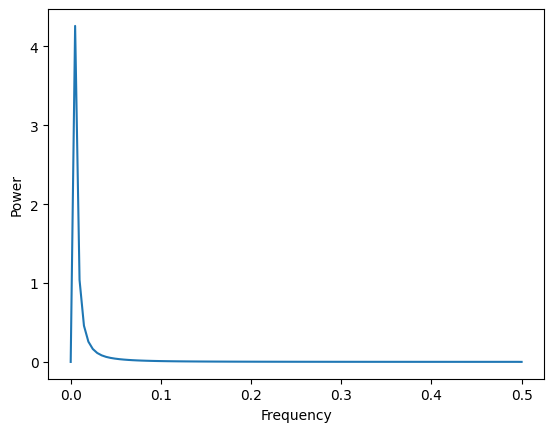

(0.004901960784313725, 'No hay evidencia de periodicidad en los datos')

In [82]:
tool.StationarityUtilities.PeriodogramTest(merge['pop'])

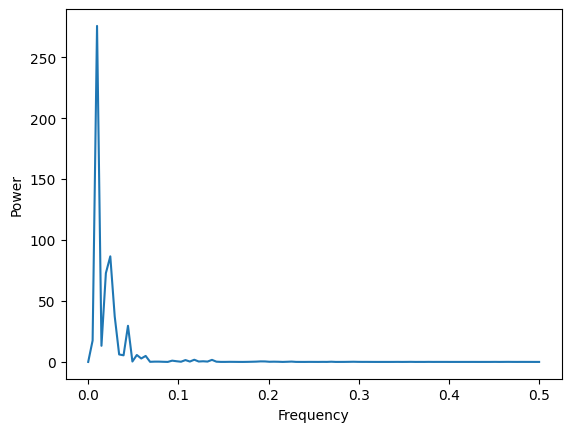

(0.00980392156862745, 'No hay evidencia de periodicidad en los datos')

In [83]:
tool.StationarityUtilities.PeriodogramTest(merge['inflacion'])

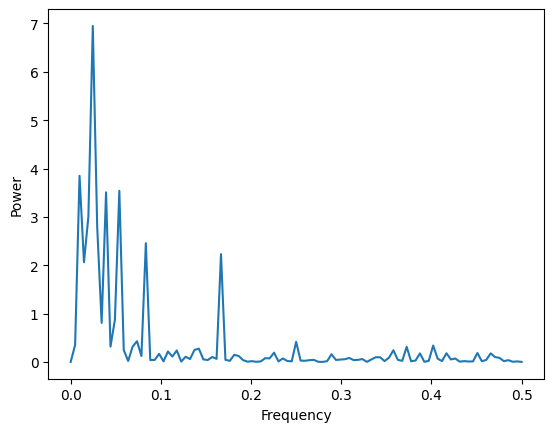

(0.024509803921568627, 'No hay evidencia de periodicidad en los datos')

In [84]:
tool.StationarityUtilities.PeriodogramTest(merge['temp'])

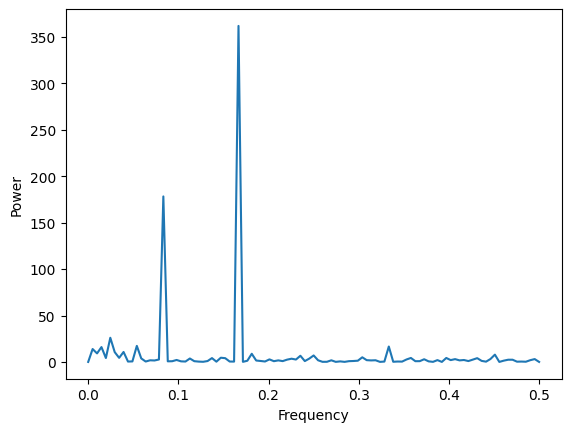

(0.16666666666666666, 'No hay evidencia de periodicidad en los datos')

In [85]:
tool.StationarityUtilities.PeriodogramTest(merge['prep'])

In [88]:
print(merge['demanda'].isnull().values.any())
print(merge['pib'].isnull().values.any())
print(merge['pop'].isnull().values.any())
print(merge['inflacion'].isnull().values.any())
print(merge['temp'].isnull().values.any())
print(merge['prep'].isnull().values.any())

False
False
False
False
False
False


In [89]:
print(tool.demand_utilities.check_zeros_in_column(merge, 'demanda'))
print(tool.demand_utilities.check_zeros_in_column(merge, 'pib'))
print(tool.demand_utilities.check_zeros_in_column(merge, 'pop'))
print(tool.demand_utilities.check_zeros_in_column(merge, 'inflacion'))
print(tool.demand_utilities.check_zeros_in_column(merge, 'temp'))
print(tool.demand_utilities.check_zeros_in_column(merge, 'prep'))

False
False
False
False
False
False


### Holidays

In [92]:
import holidays
co_holidays = holidays.Colombia()
co_holidays

holidays.country_holidays('CO')

In [93]:
# Convertir columna "fecha" a datetime
merge['fecha'] = pd.to_datetime(merge['fecha'])

# Contar el número de días festivos en cada mes del dataframe
holidays_count = merge['fecha'].apply(lambda x: co_holidays.get(x.date()) is not None).groupby(merge['fecha'].dt.to_period('M')).sum()
merge['holidays_count']=holidays_count

### Exploratory

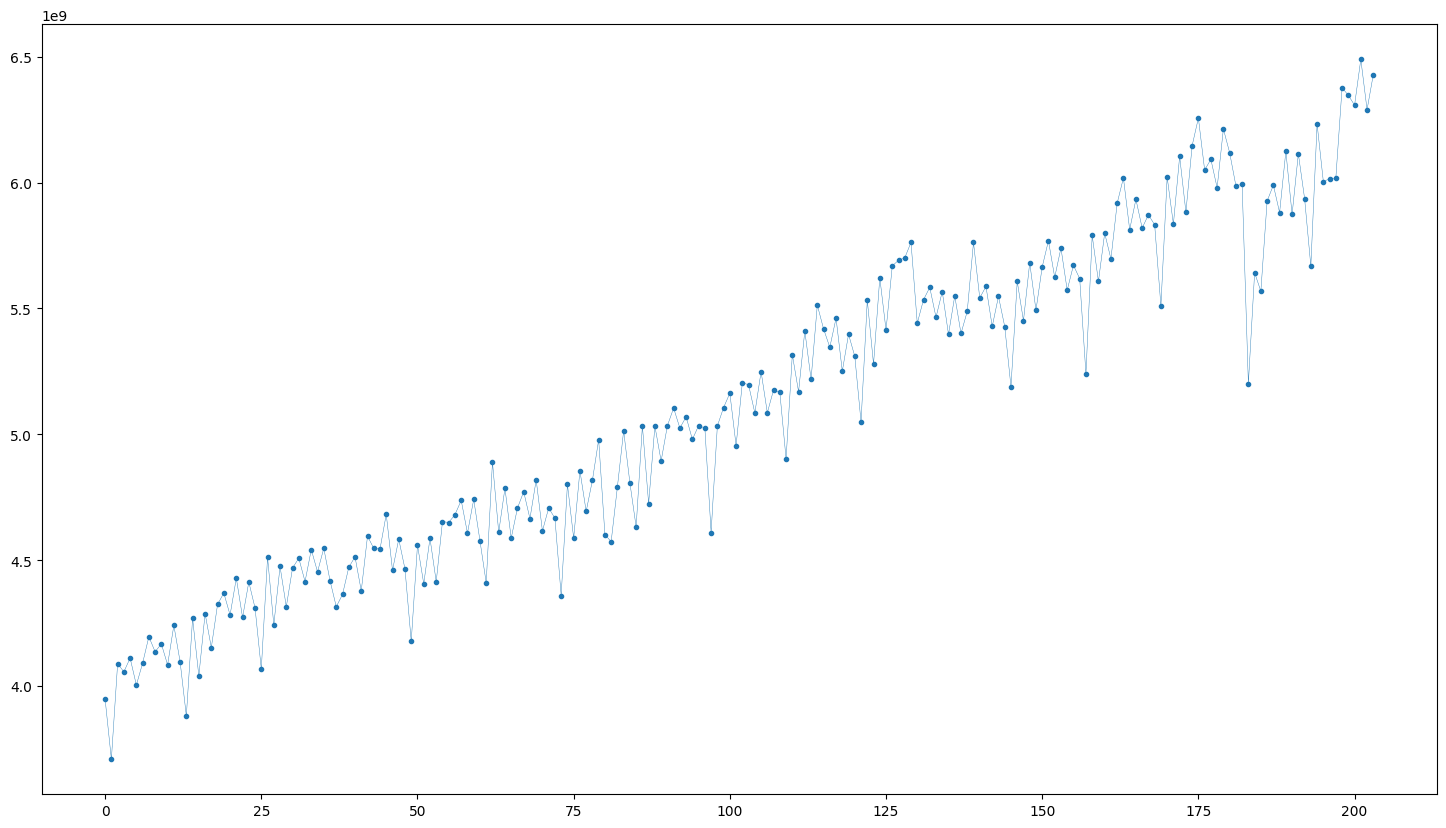

In [94]:
# graficando Adj Close
plot = merge['demanda'].plot(figsize=(18, 10),linewidth=0.3,marker='.',linestyle='-')

In [96]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

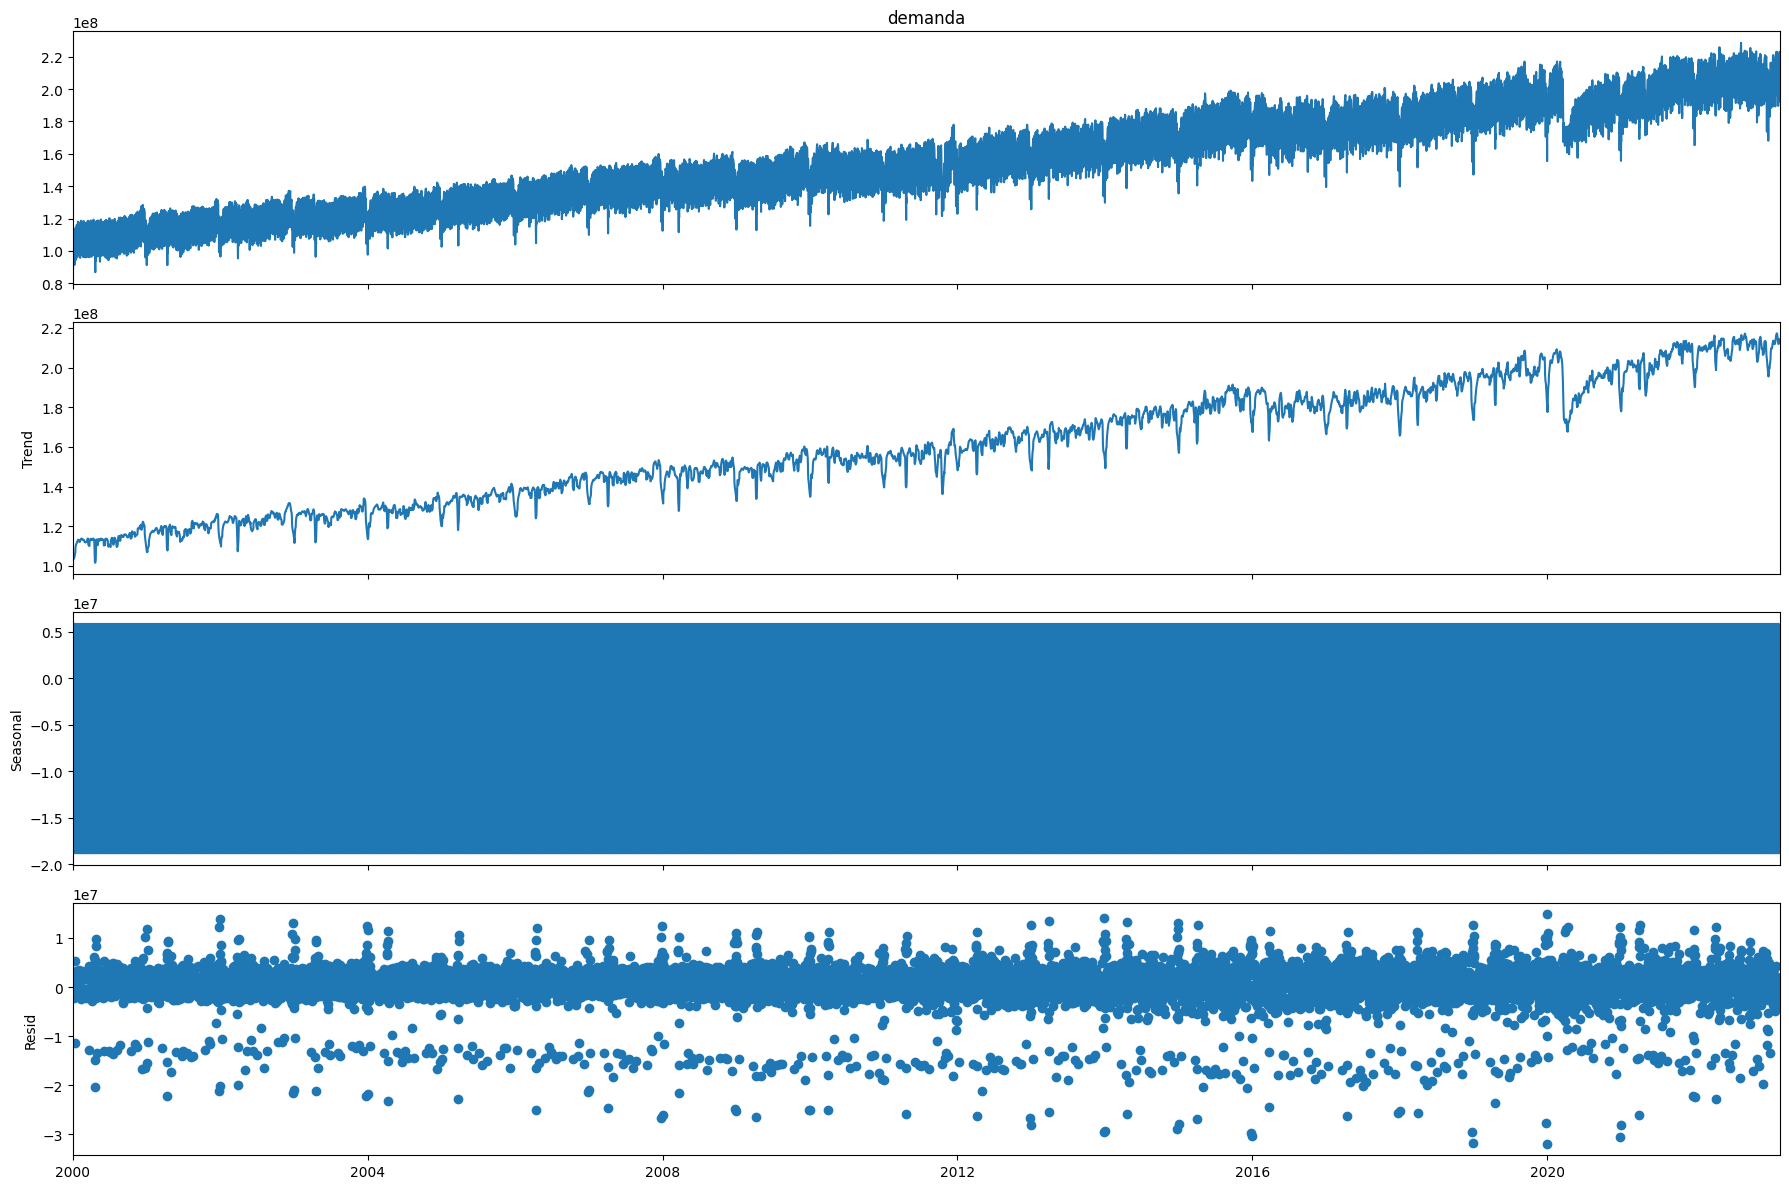

In [23]:
# Multiplicative Decomposition 
from matplotlib.pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose

rcParams['figure.figsize'] = 18, 12

result_additive = seasonal_decompose(df_dayli['demanda'],
                                     model='additive')

fig = result_additive.plot()

In [52]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [53]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

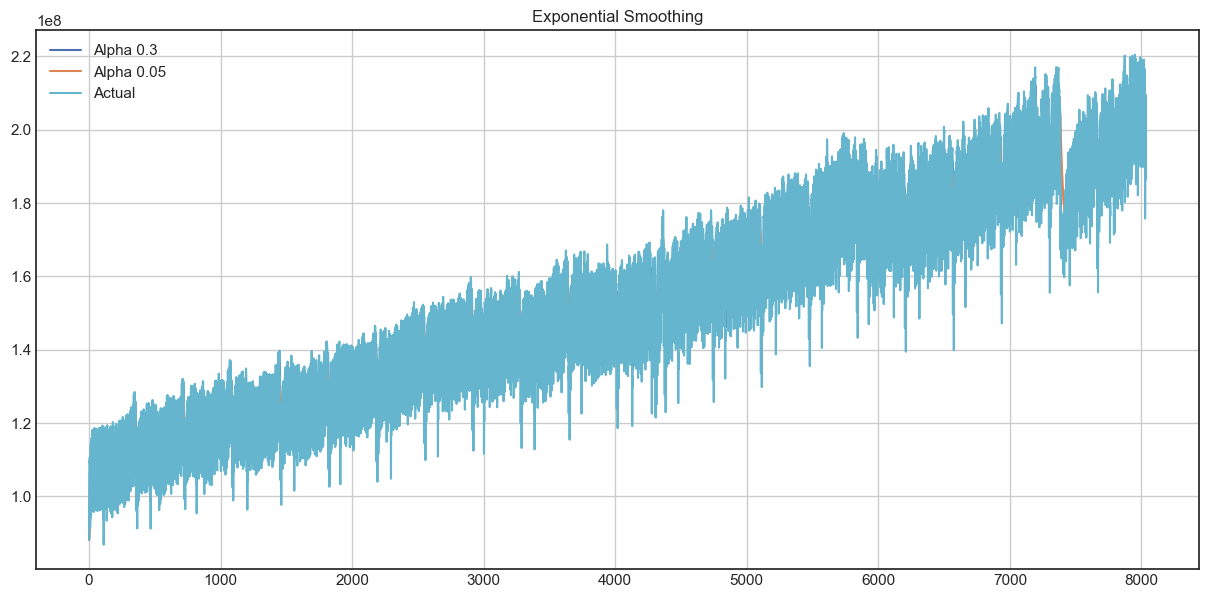

In [56]:
plotExponentialSmoothing(demand_df['Demanda Energia SIN kWh'], [0.3, 0.05])

In [57]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

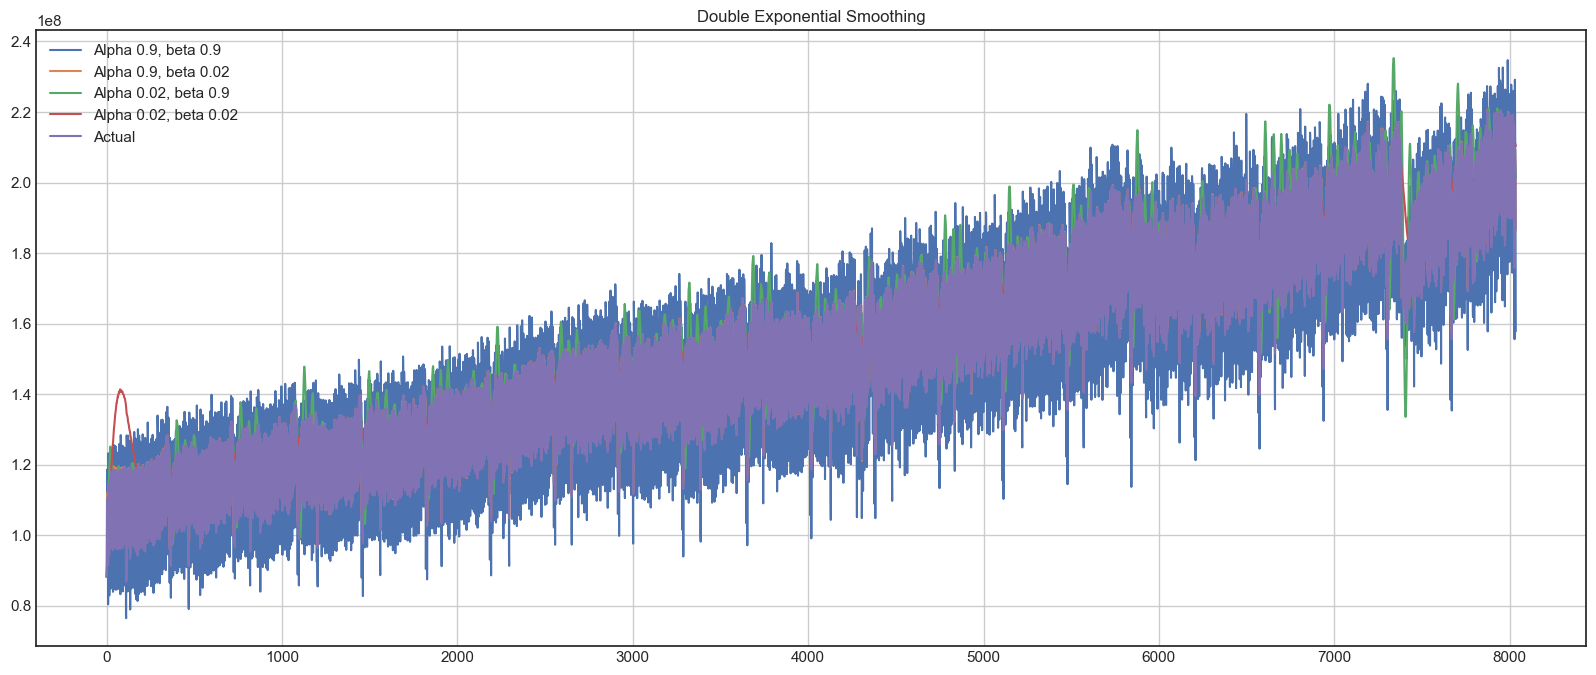

In [58]:
plotDoubleExponentialSmoothing(demand_df['Demanda Energia SIN kWh'], alphas=[0.9, 0.02], betas=[0.9, 0.02])

### Entender la naturaleza de la serie de tiempo

In [14]:
#demand.reset_index(inplace=True)

In [17]:
# Contar el número de observaciones por día
df_count = demand.resample("D").count()
print(df_count)

2           Demanda Energia SIN kWh  Generación kWh
Fecha                                              
2000-01-01                        1               1
2000-01-02                        1               1
2000-01-03                        1               1
2000-01-04                        1               1
2000-01-05                        1               1
...                             ...             ...
2021-12-27                        1               1
2021-12-28                        1               1
2021-12-29                        1               1
2021-12-30                        1               1
2021-12-31                        1               1

[8036 rows x 2 columns]


In [18]:
demand.reset_index(inplace=True)

# Filtramos por el día
dia = '2015-12-31'
df_filtrado = demand[demand['Fecha'].dt.date == pd.to_datetime(dia).date()]
df_filtrado

2,Fecha,Demanda Energia SIN kWh,Generación kWh
5843,2015-12-31,0,0


In [19]:
# Verificamos si alguna columna tiene valores diferentes a 1
if (df_count.ne(1).any(axis=0)).any():
    print('Hay al menos una columna con valores diferentes a 1')
else:
    print('Todos los valores de todas las columnas son 1')

Todos los valores de todas las columnas son 1


In [20]:
# Verificar si alguna columna es diferente de 1
mask = (df_count != 1).any(axis=1)

# Filtrar las filas que cumplen la condición
filas_diferentes_de_1 = df_count[mask]

In [21]:
filas_diferentes_de_1

2,Demanda Energia SIN kWh,Generación kWh
Fecha,,


In [16]:
demand.tail()

2,Fecha,Demanda Energia SIN kWh,Generación kWh,Demanda No Atendida kWh,year,month,day
8031,2021-12-27,208977010.39,200380765.9,32110,2021,12,27
8032,2021-12-28,209586419.72,201250569.11,12400,2021,12,28
8033,2021-12-29,207256813.61,200027723.99,1720,2021,12,29
8034,2021-12-30,203614873.8,199198217.16,26690,2021,12,30
8035,2021-12-31,186399882.01,182449168.89,123260,2021,12,31


In [25]:
# Agrupar por año y contar el número de filas
conteo_por_anio = demand.groupby(demand['Fecha'].dt.year)['Demanda Energia SIN kWh'].count()

# Mostrar el resultado
print(conteo_por_anio)

Fecha
2000    366
2001    365
2002    365
2003    365
2004    366
2005    365
2006    365
2007    365
2008    366
2009    365
2010    365
2011    365
2012    366
2013    365
2014    365
2015    365
2016    366
2017    365
2018    365
2019    365
2020    366
2021    365
Name: Demanda Energia SIN kWh, dtype: int64


In [2]:
import pandas as pd
import numpy as np

# Generamos un dataframe con fechas aleatorias
df = pd.DataFrame({'fecha': pd.date_range('2022-01-01', '2022-01-31', freq='D')})
import pandas as pd
import numpy as np

def obtener_dias_laborables(df, columna_fecha):
    # Creamos una nueva columna con la información de si es laboral o no
    df['es_laboral'] = np.isin(df[columna_fecha].dt.weekday, [0, 1, 2, 3, 4])
    
    return df


In [3]:
# Llamamos a la función y mostramos los primeros 5 registros del dataframe resultante
df = obtener_dias_laborables(df, 'fecha')
print(df.head())


       fecha  es_laboral
0 2022-01-01       False
1 2022-01-02       False
2 2022-01-03        True
3 2022-01-04        True
4 2022-01-05        True


In [5]:
import holidays

def find_colombian_holidays(df, date_column_name):
    co_holidays = holidays.Colombia()
    df['colombian_holiday'] = df[date_column_name].apply(lambda x: x in co_holidays)
    return df


In [6]:
import pandas as pd

# Creamos un dataframe de ejemplo con algunas fechas
df = pd.DataFrame({
    'date': ['2022-01-01', '2022-01-02', '2022-01-03', '2022-12-24', '2022-12-25']
})

# Llamamos a la función para encontrar días festivos en Colombia
df = find_colombian_holidays(df, 'date')

# Mostramos el dataframe resultante
print(df)


         date  colombian_holiday
0  2022-01-01               True
1  2022-01-02              False
2  2022-01-03              False
3  2022-12-24              False
4  2022-12-25               True


In [ ]:
demand['year']=demand.index.year
demand['month']=demand.index.month
demand['day']=demand.index.day

demand['Demanda Energia SIN kWh'].pct_change()